In [1]:
# The below libaries are specific to the skeltonize processing function and the fil_finder library requires you use pip
import astropy.units
from fil_finder import FilFinder2D
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import pandas as pd
import pygmt
import shutil
from skimage.morphology import skeletonize, flood_fill
import sys
import xarray as xr

In [2]:
import skeletonFunctions

import importlib
importlib.reload(skeletonFunctions)

<module 'skeletonFunctions' from '/Users/jono/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/makeSkeltons/skeletonFunctions.py'>

## Implementing the gateways

Also contained here are grids that have been coarsened to the model resolution. In this part we will 'overlay' the skeletons on the coarse grids, then enforce gateways.

In [3]:
coarsenedPath = 'filtered_coarsened_grids'

coarsened_90.nc
90
Lat extent of big cell: (-56.25, -50.625)
Lon extent of big cell: (-50.625, -45.0)
Lat, Lon of the skeleton cell: (-53.4375, -47.8125)

Lat extent of big cell: (-50.625, -45.0)
Lon extent of big cell: (-50.625, -45.0)
Lat, Lon of the skeleton cell: (-47.8125, -47.8125)

Lat extent of big cell: (16.875, 22.5)
Lon extent of big cell: (-67.5, -61.875)
Lat, Lon of the skeleton cell: (19.6875, -64.6875)

Lat extent of big cell: (16.875, 22.5)
Lon extent of big cell: (-61.875, -56.25)
Lat, Lon of the skeleton cell: (19.6875, -59.0625)

Lat extent of big cell: (16.875, 22.5)
Lon extent of big cell: (-56.25, -50.625)
Lat, Lon of the skeleton cell: (19.6875, -53.4375)

Lat extent of big cell: (22.5, 28.125)
Lon extent of big cell: (-73.125, -67.5)
Lat, Lon of the skeleton cell: (25.3125, -70.3125)

Lat extent of big cell: (22.5, 28.125)
Lon extent of big cell: (-67.5, -61.875)
Lat, Lon of the skeleton cell: (25.3125, -64.6875)

Lat extent of big cell: (33.75, 39.375)
Lon exte

/var/folders/hp/drslwmbd3r7502z1wfd_w7bw0000gr/T/ipykernel_76807/161344231.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.matshow(topo)


Lat extent of big cell: (-84.375, -78.75)
Lon extent of big cell: (-101.25, -95.625)
Lat, Lon of the skeleton cell: (-81.5625, -98.4375)

Lat extent of big cell: (-84.375, -78.75)
Lon extent of big cell: (-95.625, -90.0)
Lat, Lon of the skeleton cell: (-81.5625, -92.8125)

Lat extent of big cell: (-84.375, -78.75)
Lon extent of big cell: (-90.0, -84.375)
Lat, Lon of the skeleton cell: (-81.5625, -87.1875)

Lat extent of big cell: (-84.375, -78.75)
Lon extent of big cell: (-84.375, -78.75)
Lat, Lon of the skeleton cell: (-81.5625, -81.5625)

Lat extent of big cell: (78.75, 84.375)
Lon extent of big cell: (-78.75, -73.125)
Lat, Lon of the skeleton cell: (81.5625, -75.9375)

Lat extent of big cell: (78.75, 84.375)
Lon extent of big cell: (-73.125, -67.5)
Lat, Lon of the skeleton cell: (81.5625, -70.3125)

Lat extent of big cell: (78.75, 84.375)
Lon extent of big cell: (-67.5, -61.875)
Lat, Lon of the skeleton cell: (81.5625, -64.6875)

Number of times the skeleton fell within a land cell:

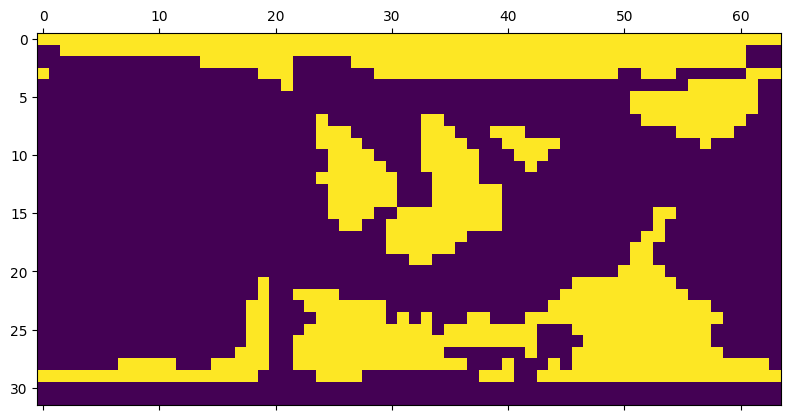

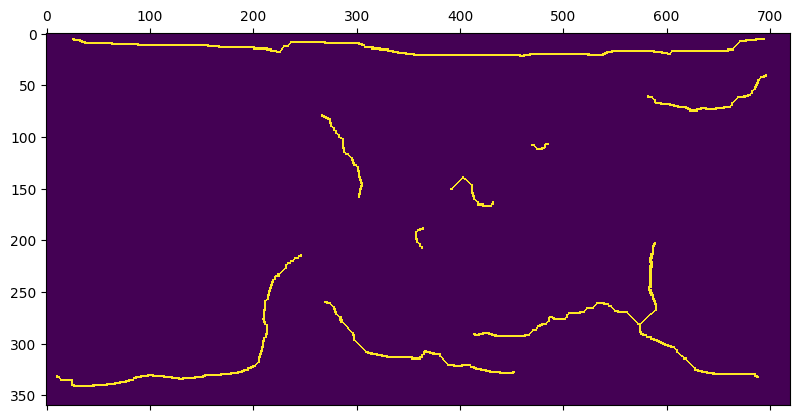

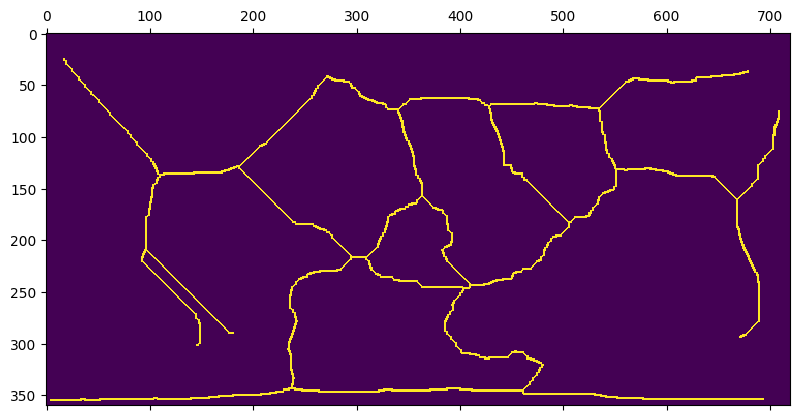

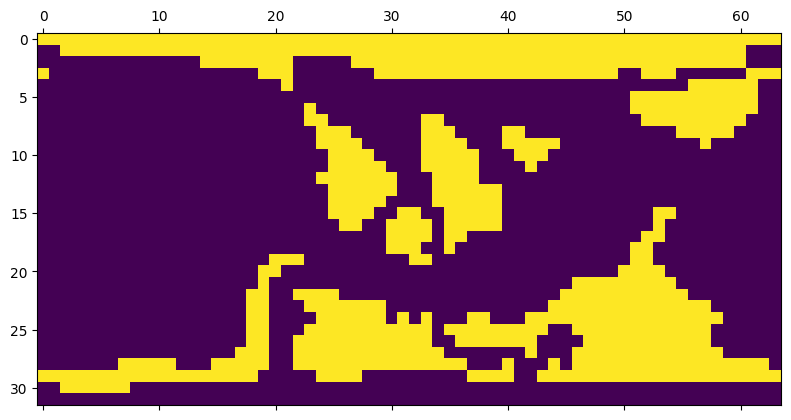

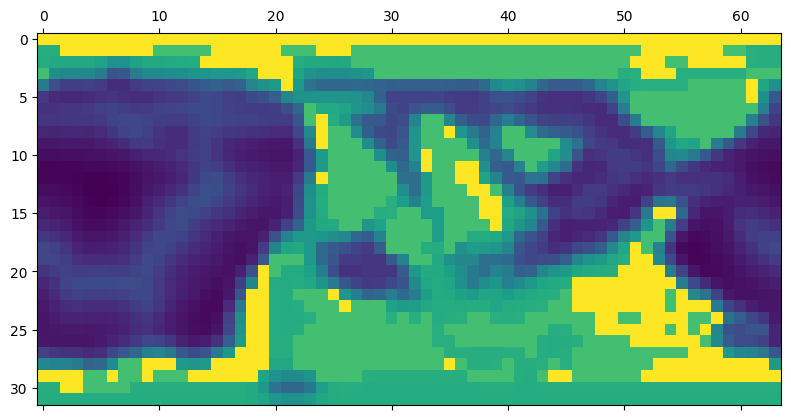

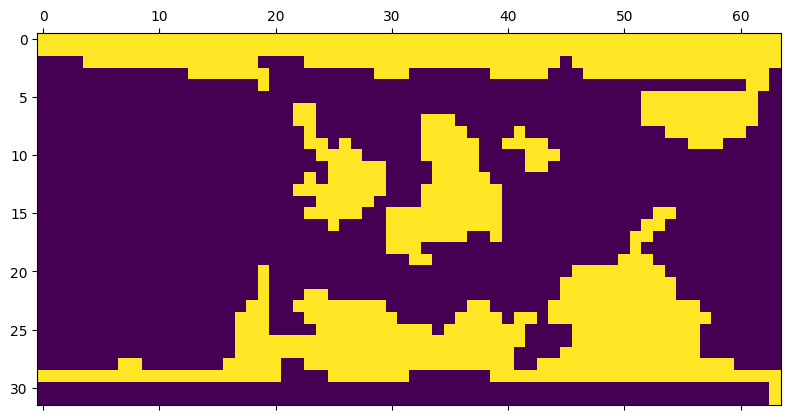

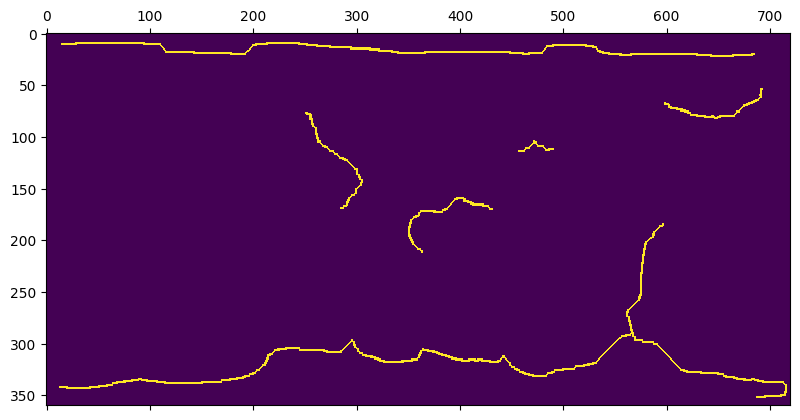

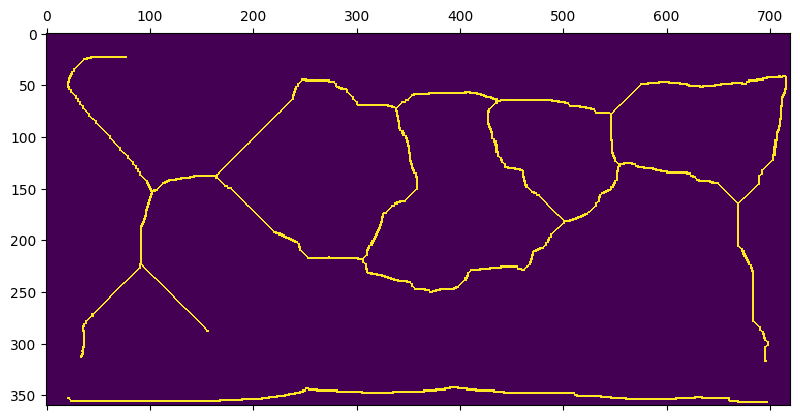

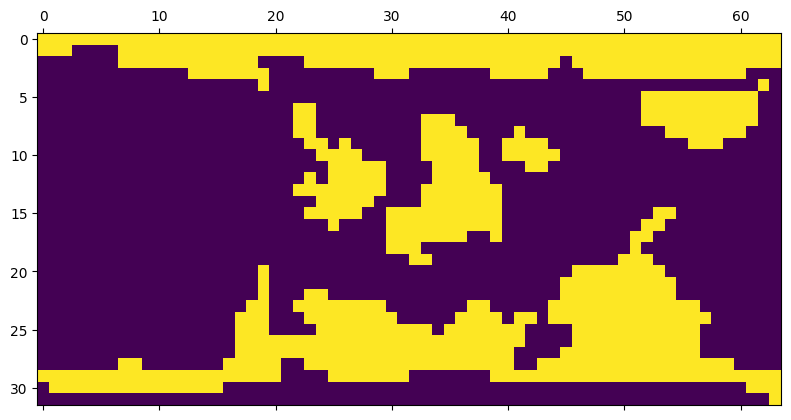

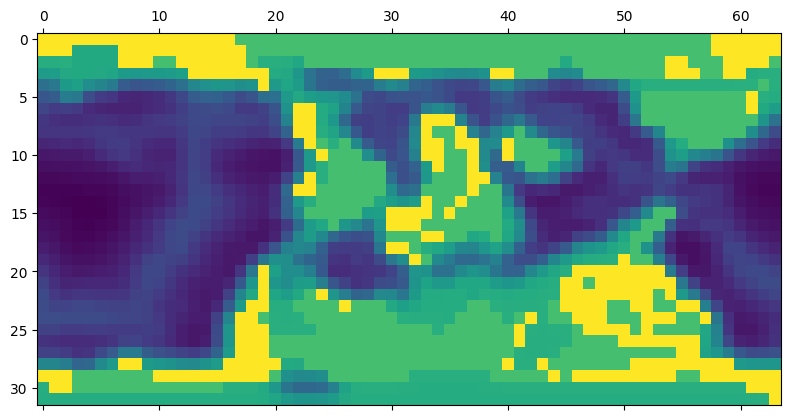

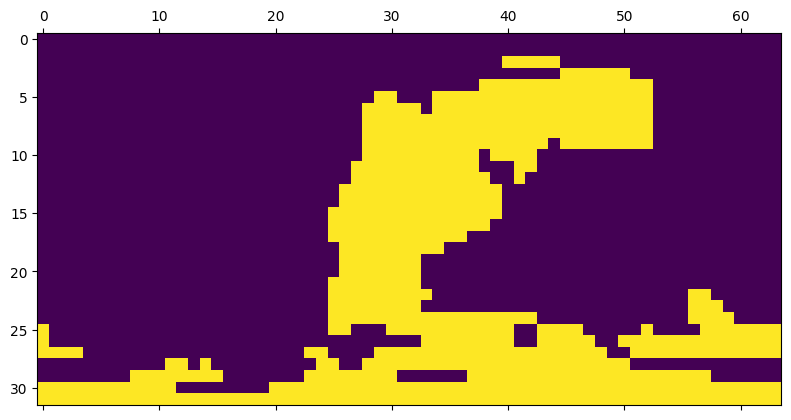

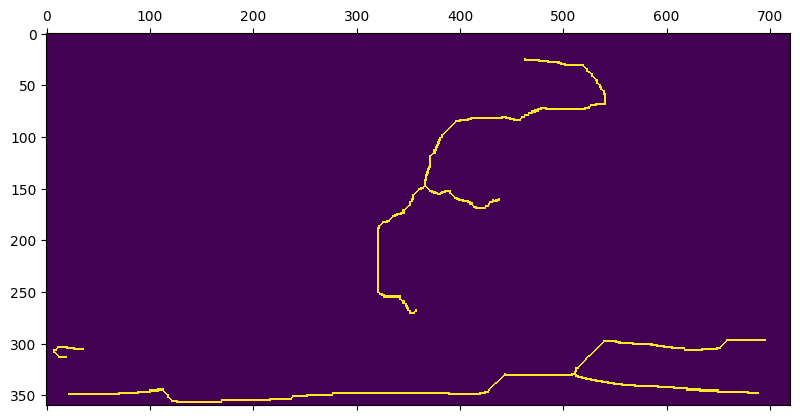

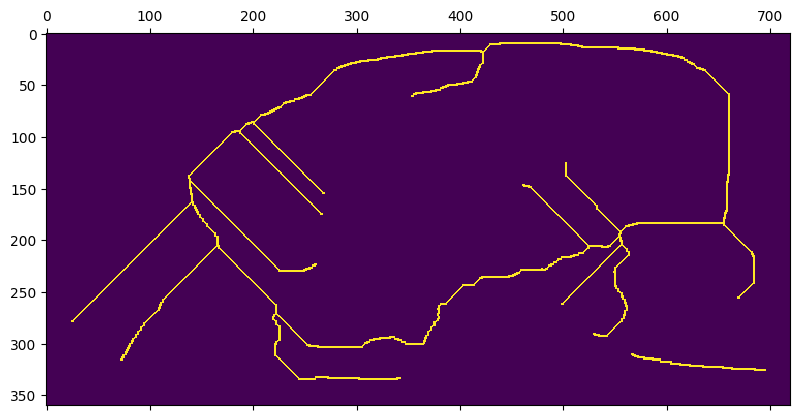

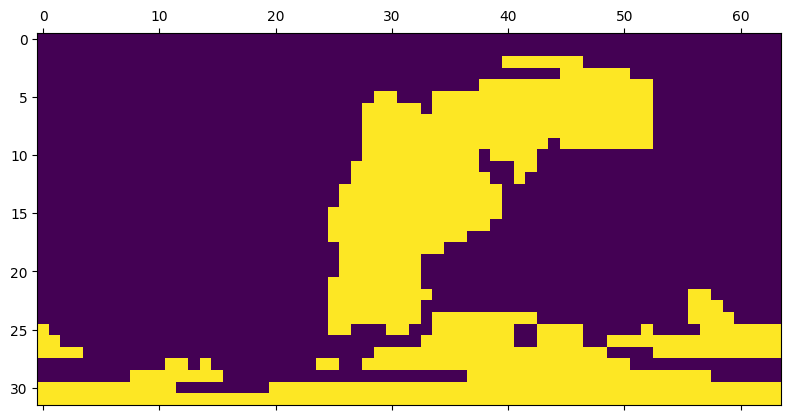

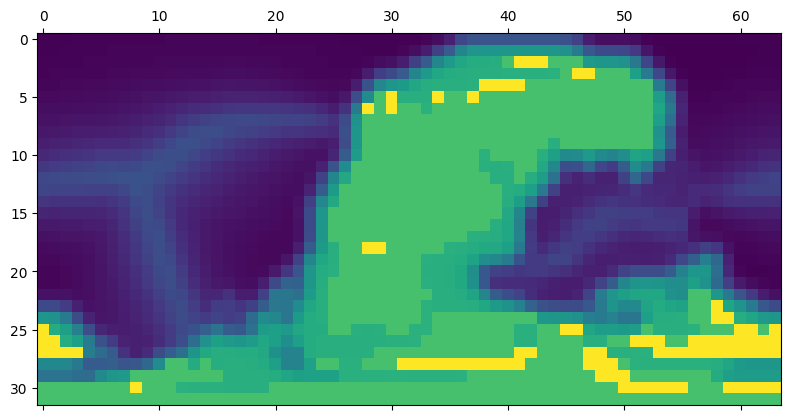

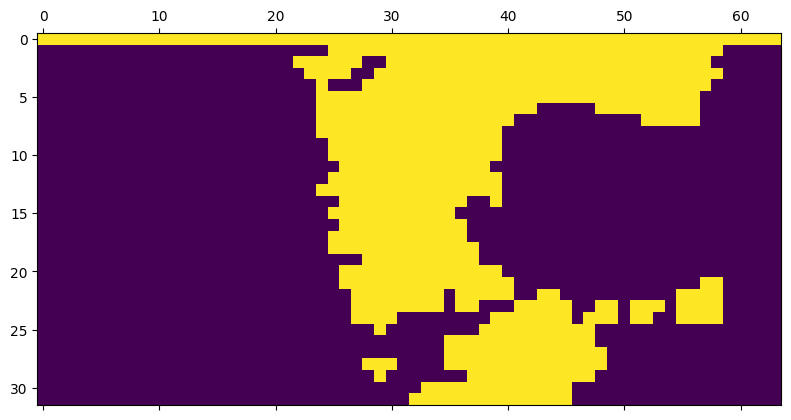

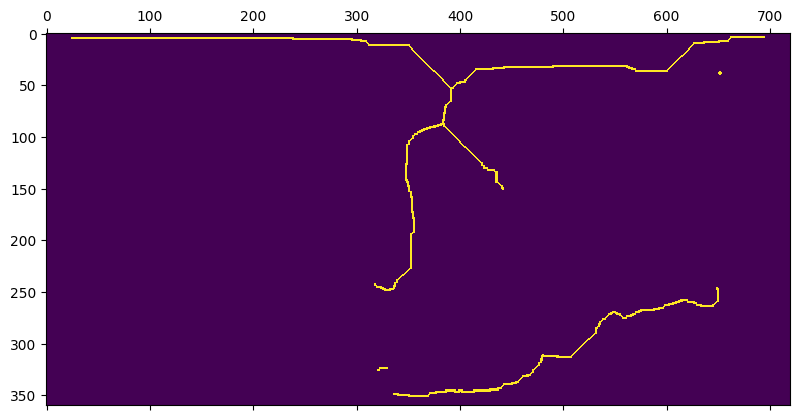

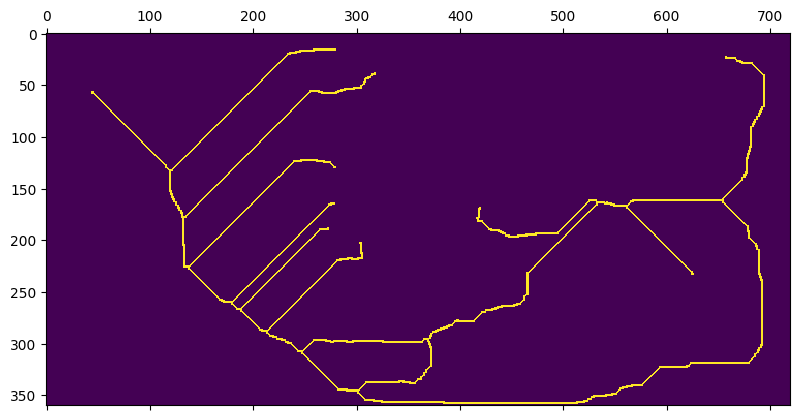

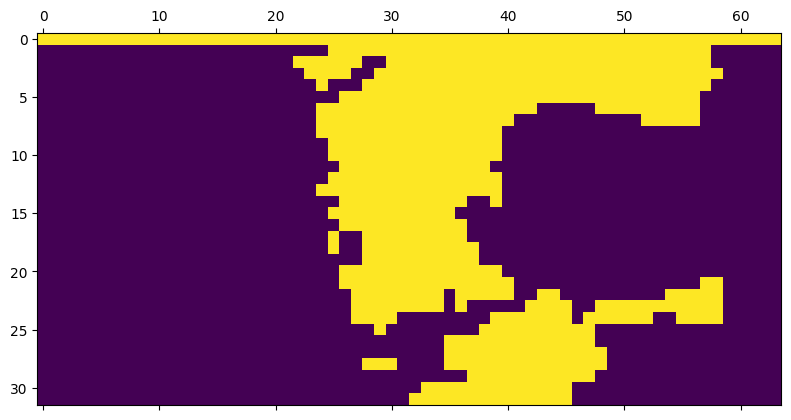

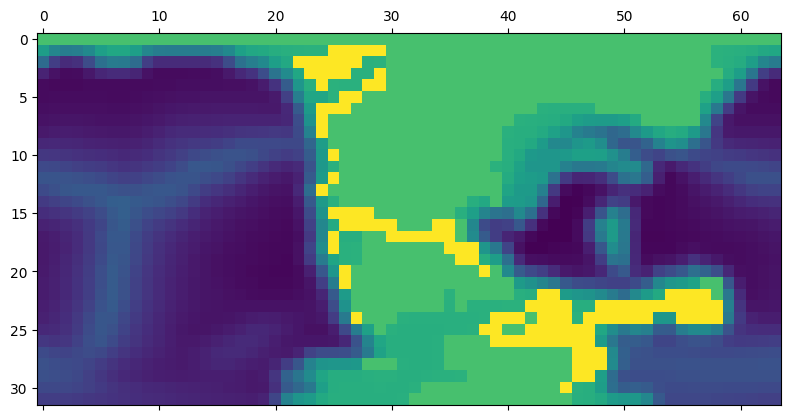

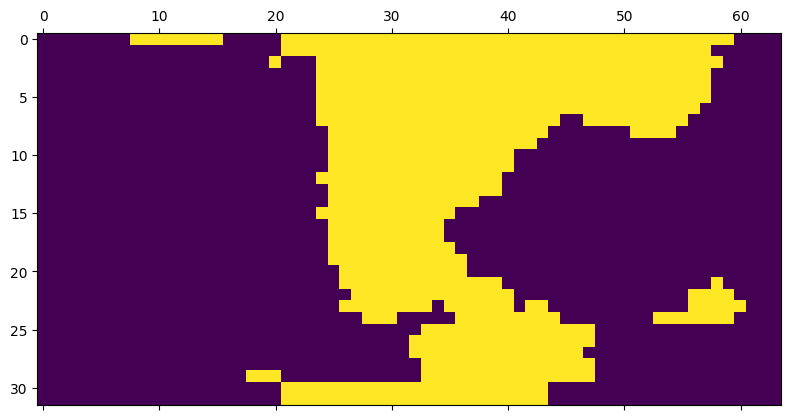

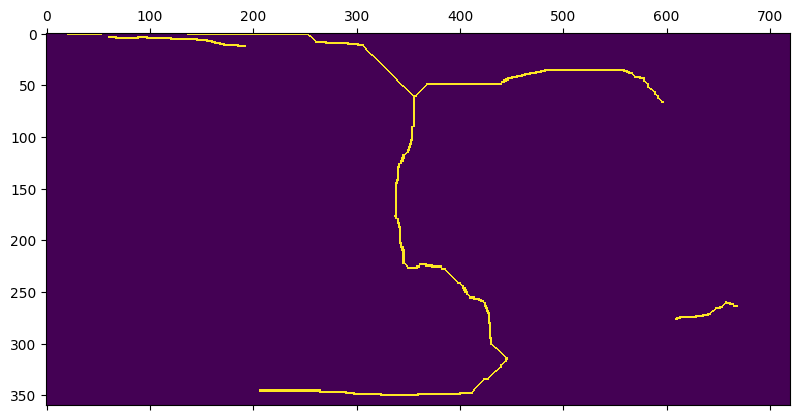

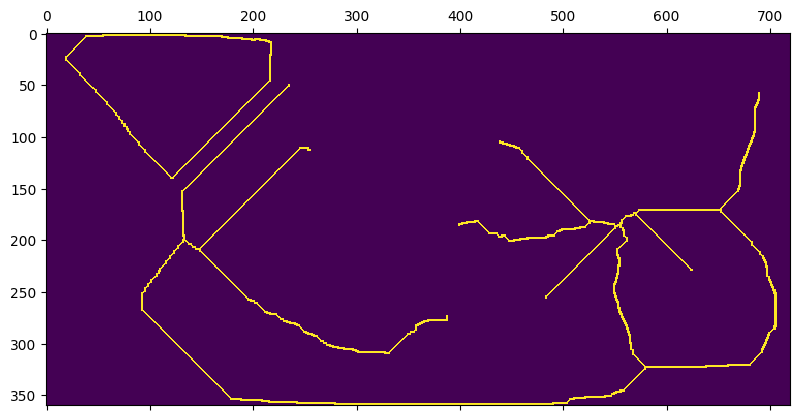

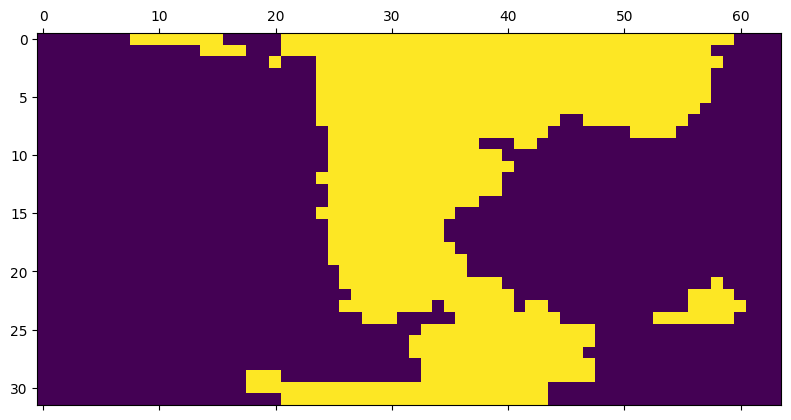

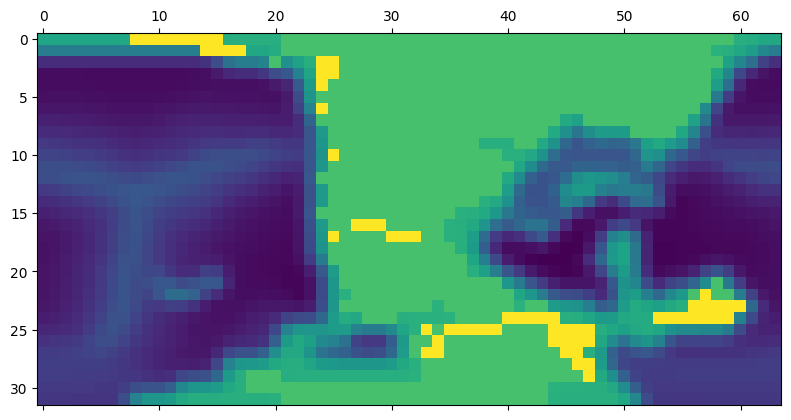

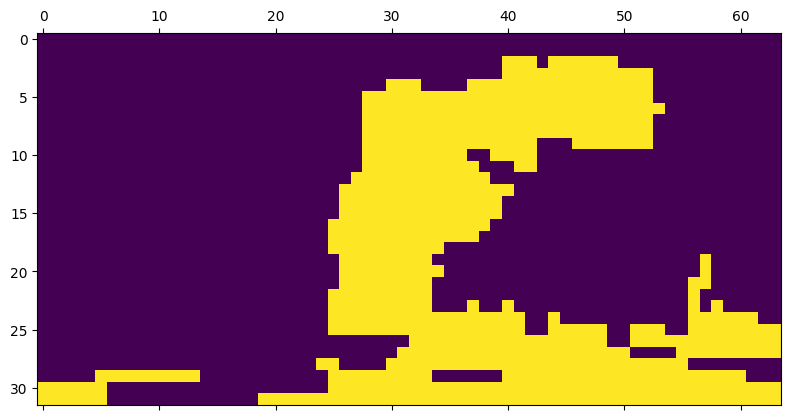

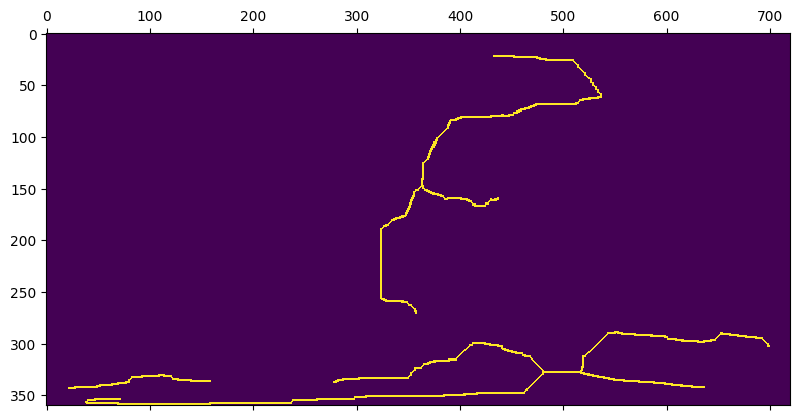

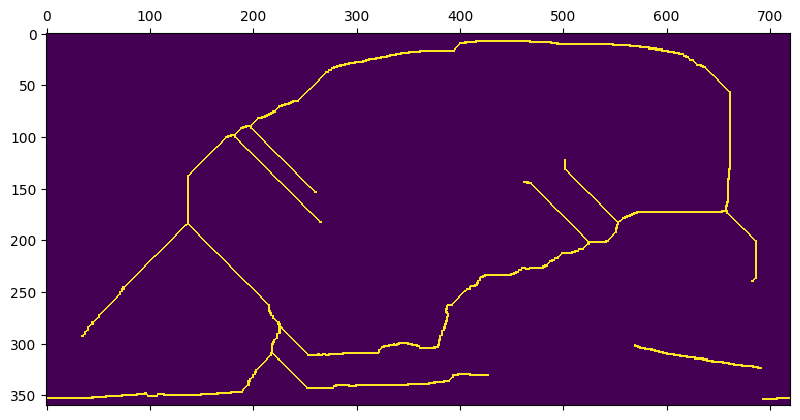

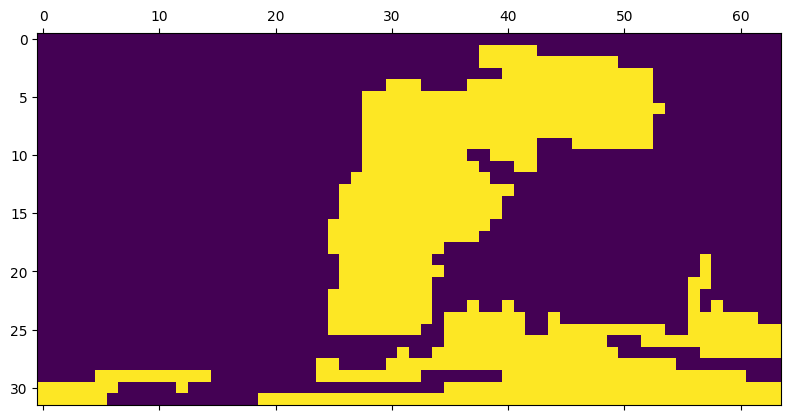

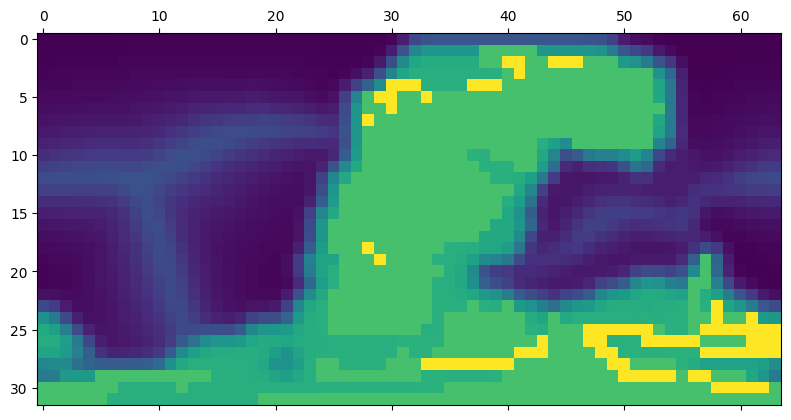

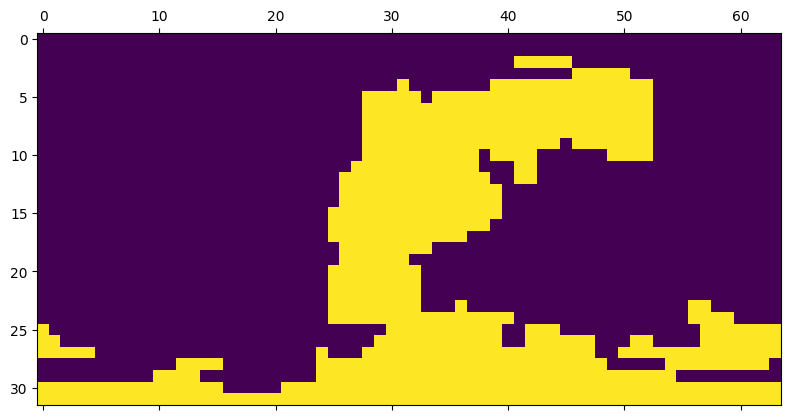

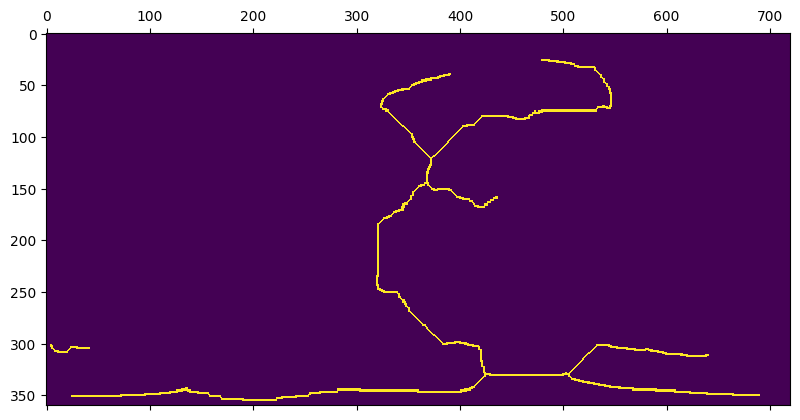

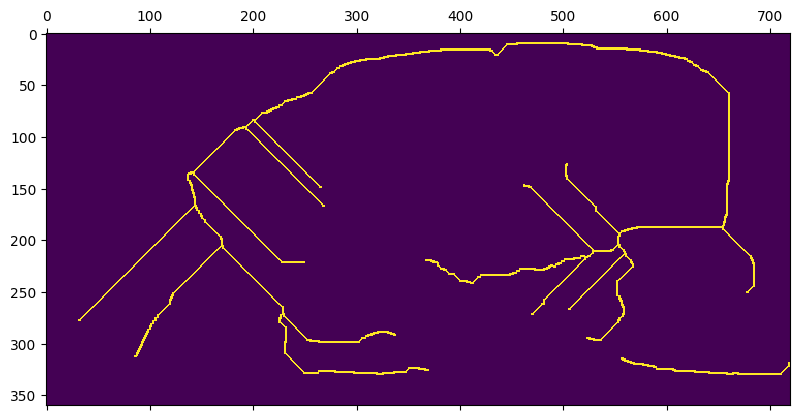

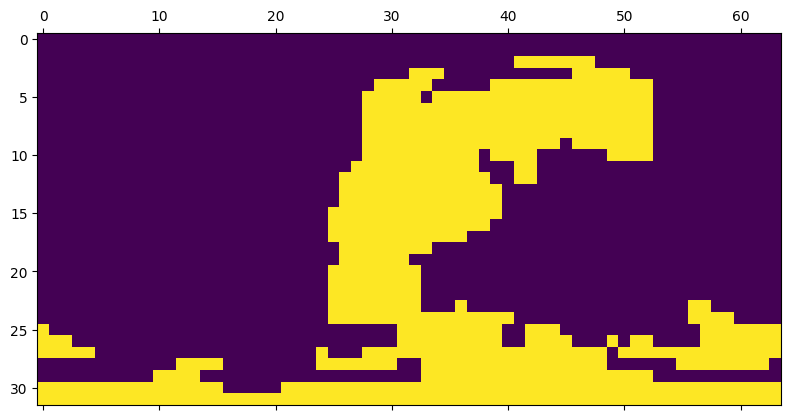

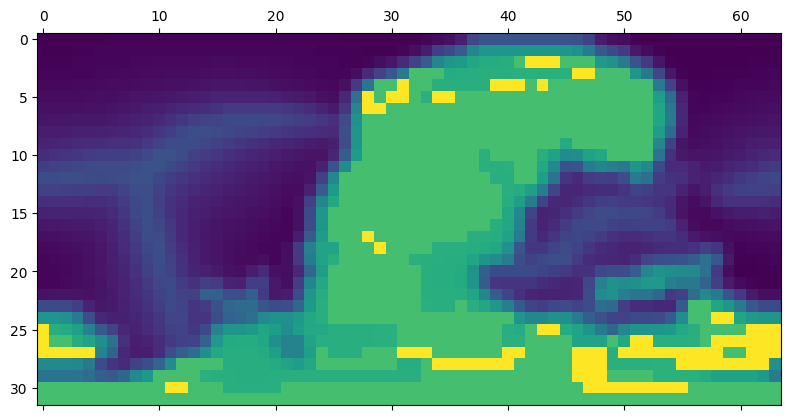

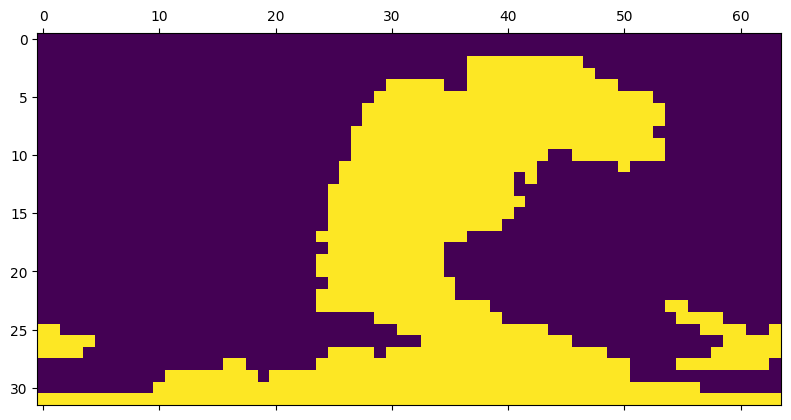

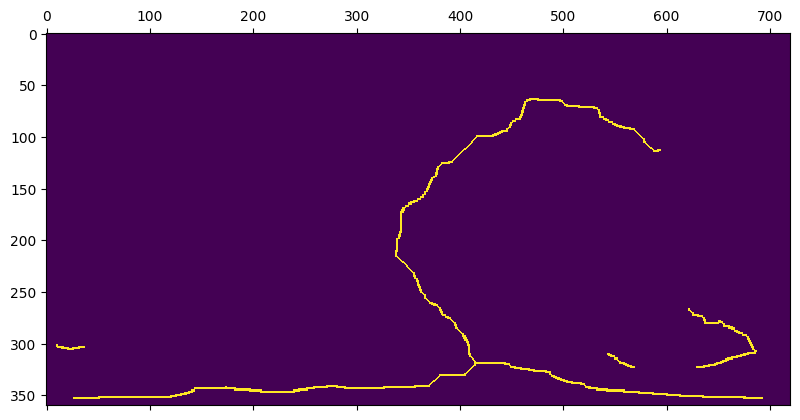

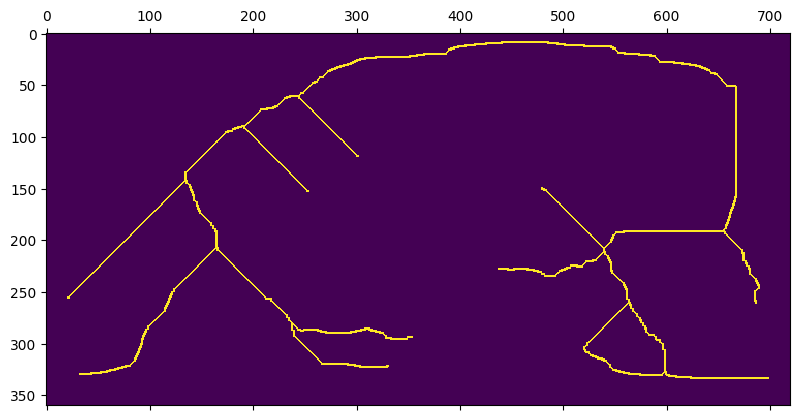

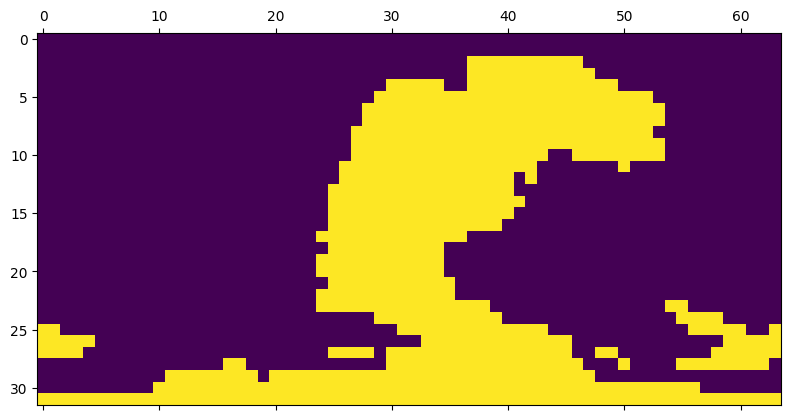

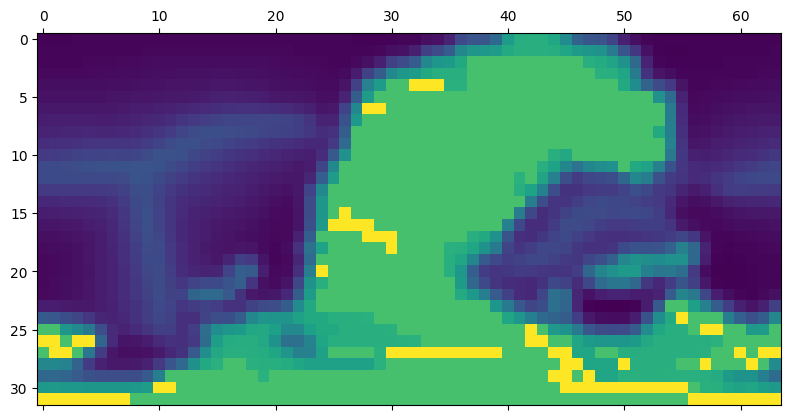

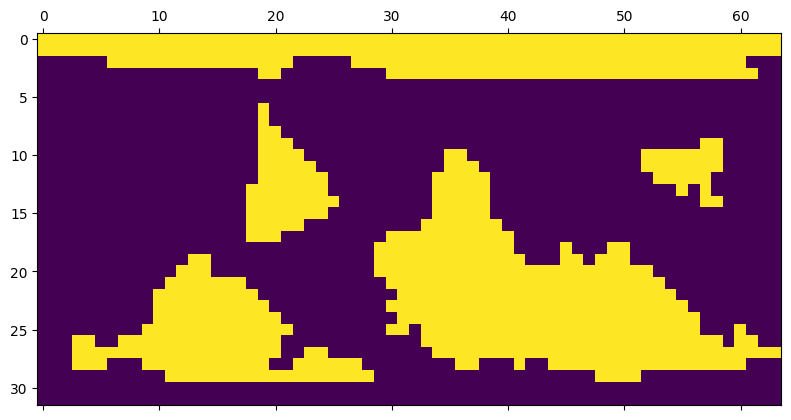

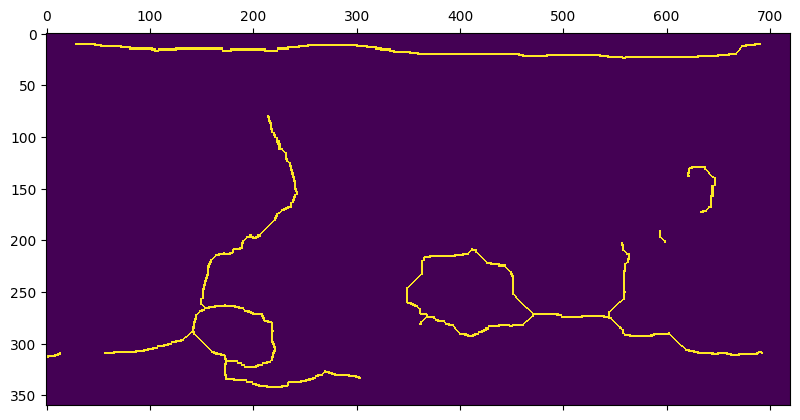

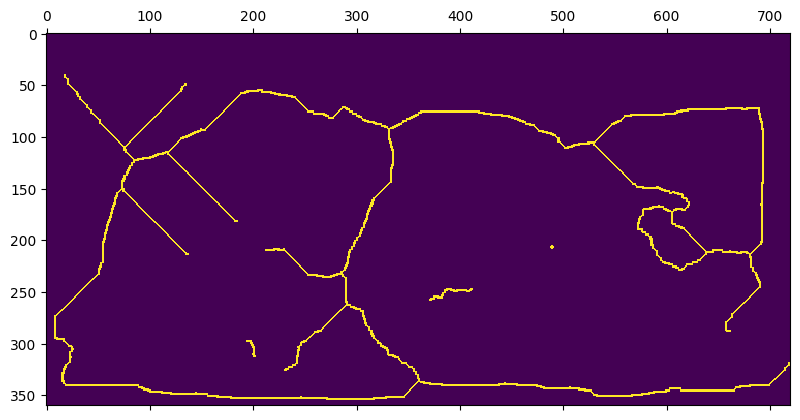

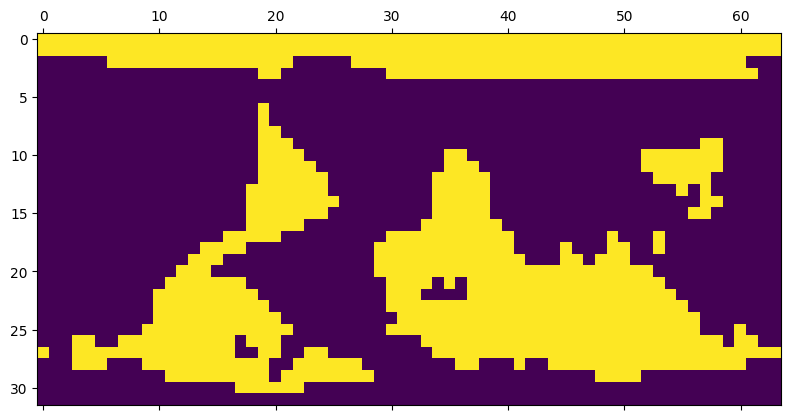

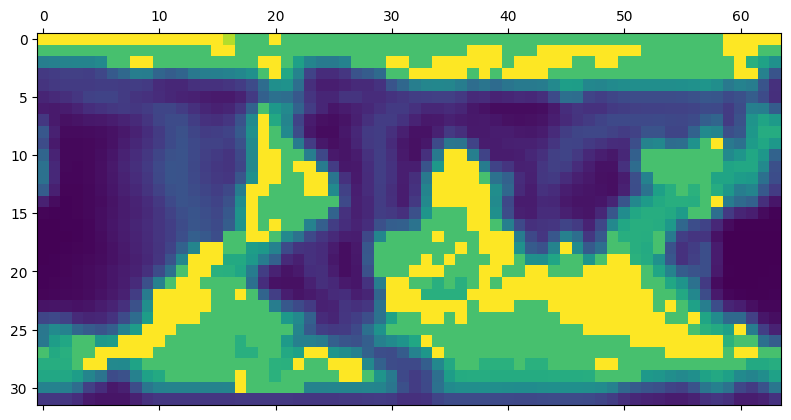

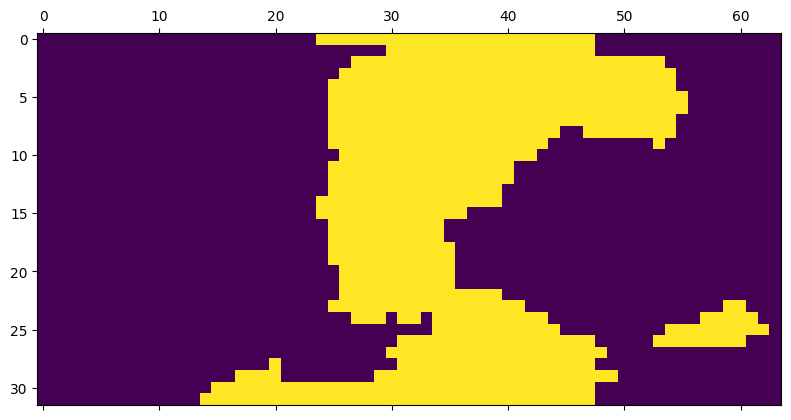

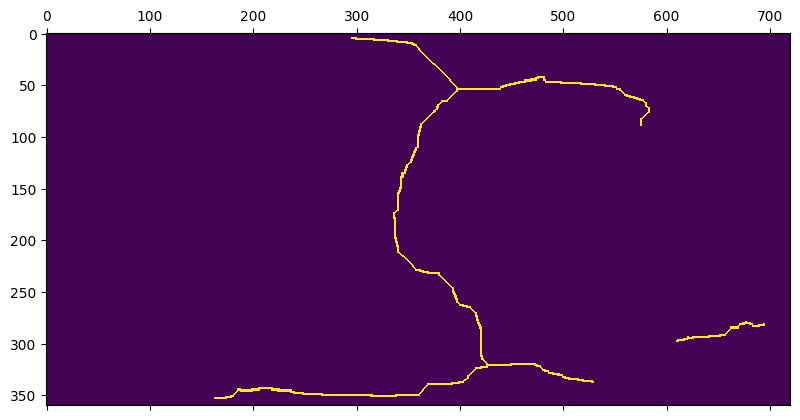

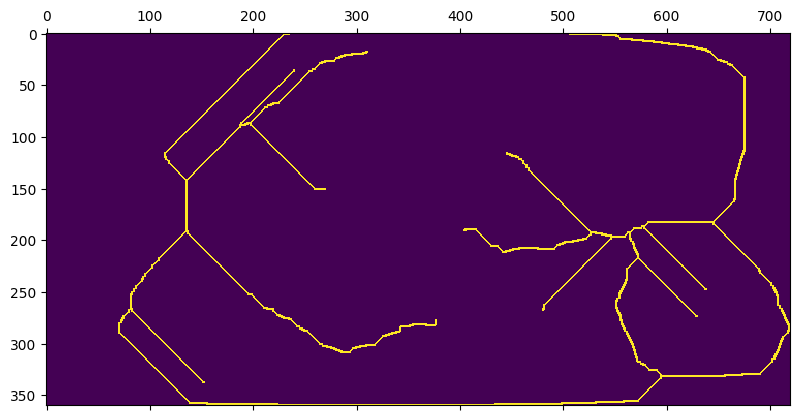

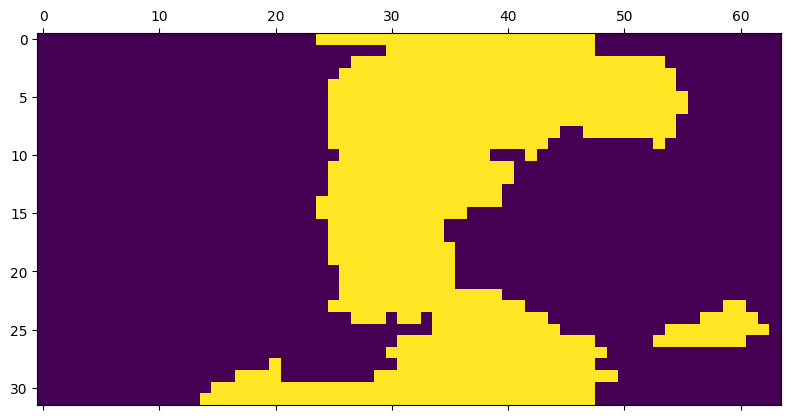

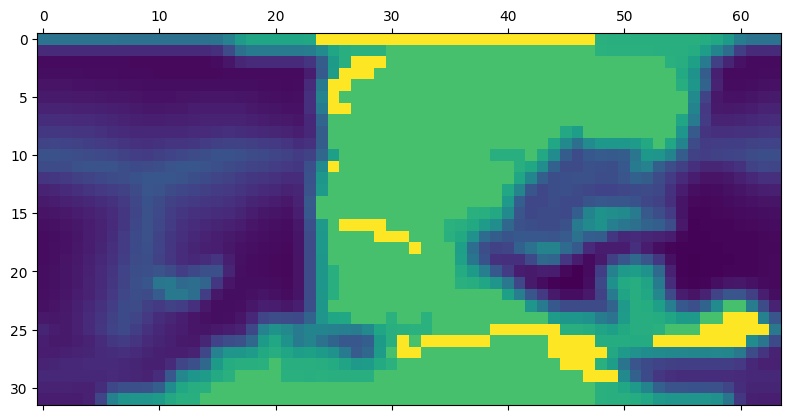

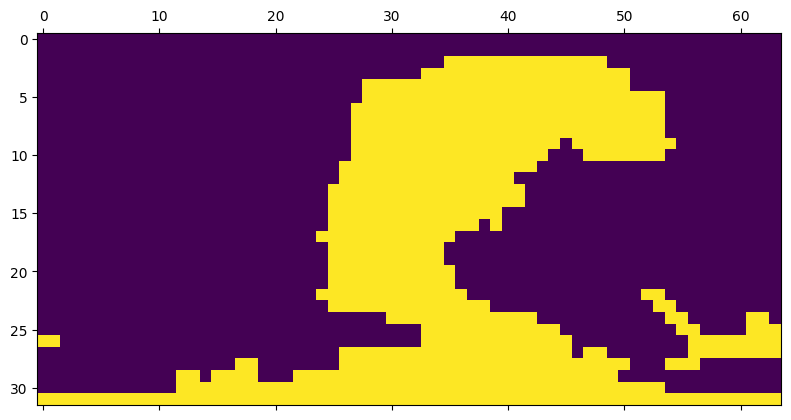

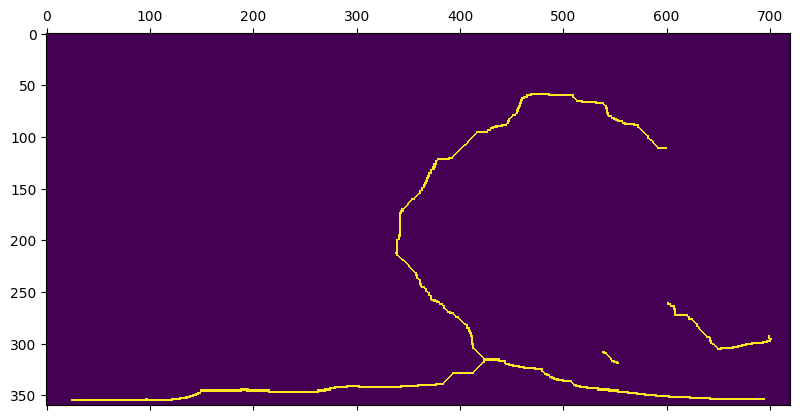

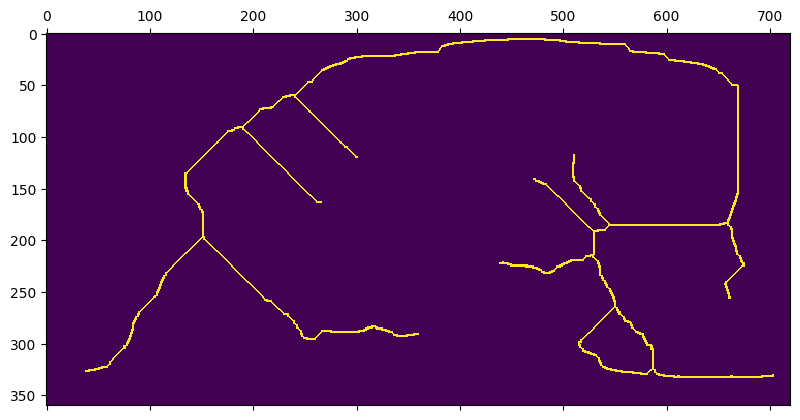

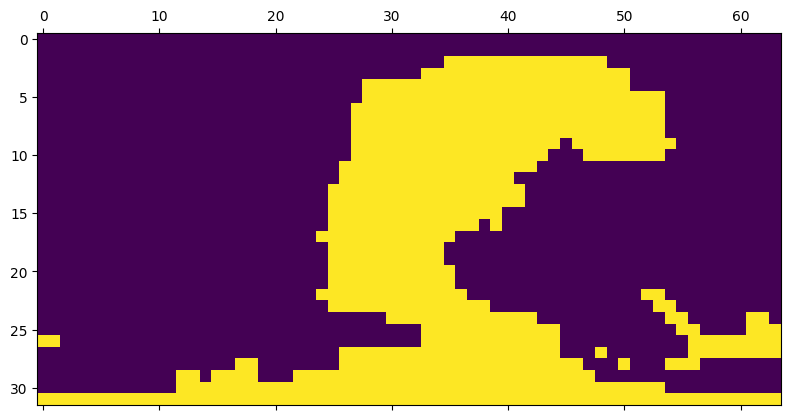

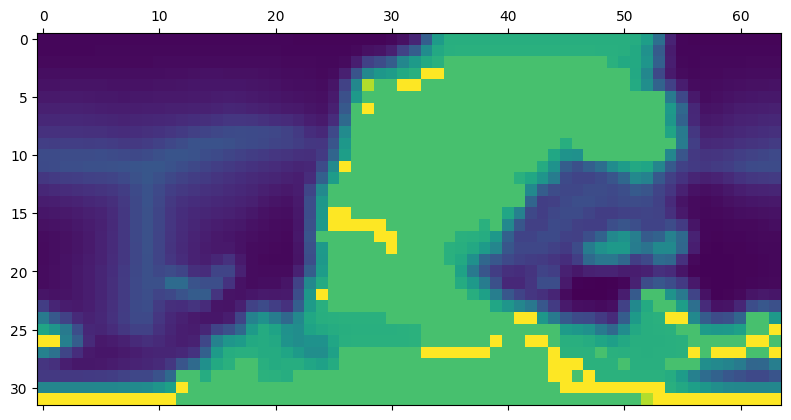

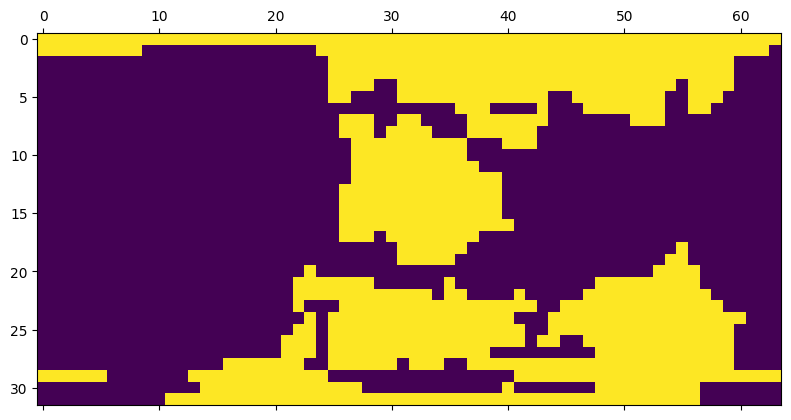

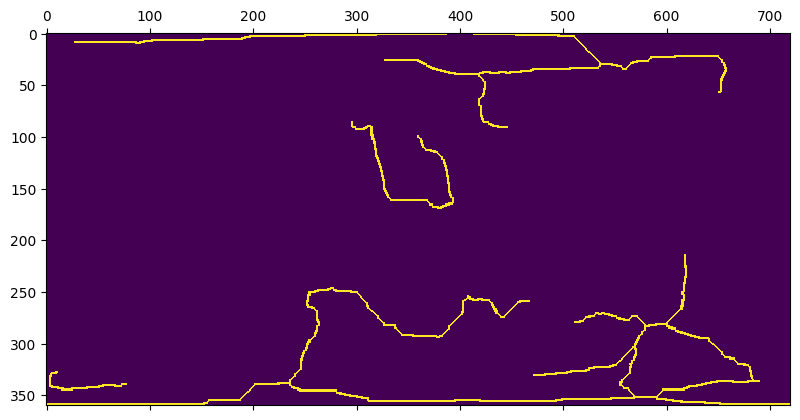

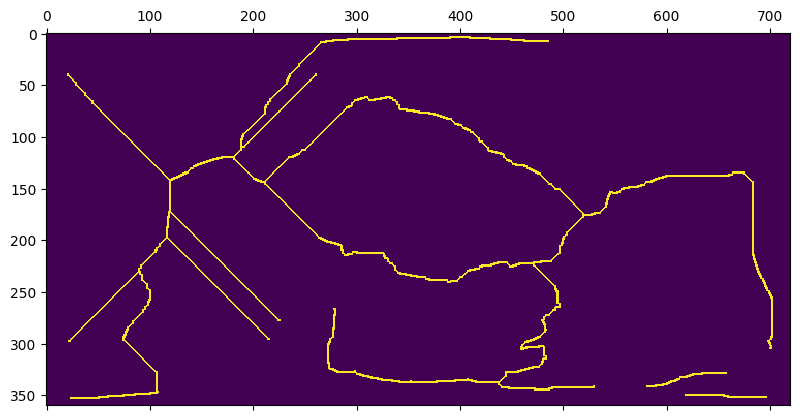

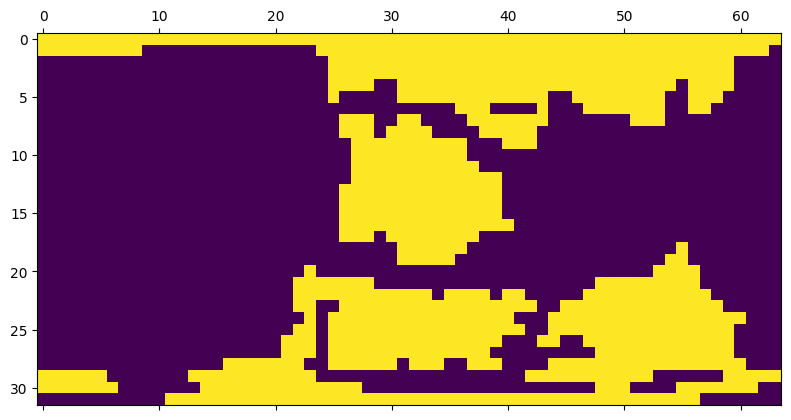

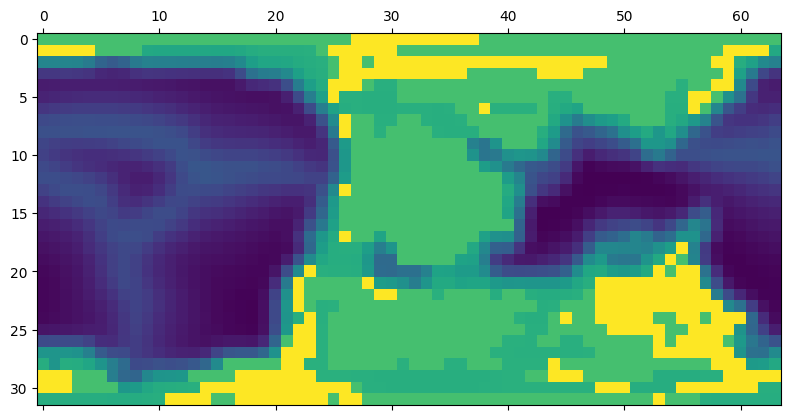

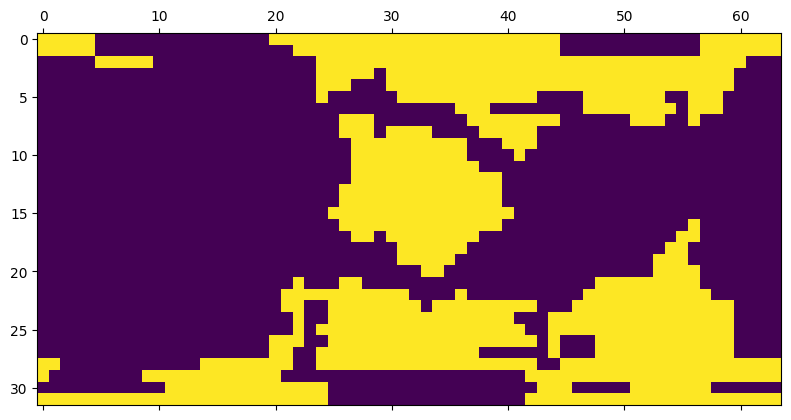

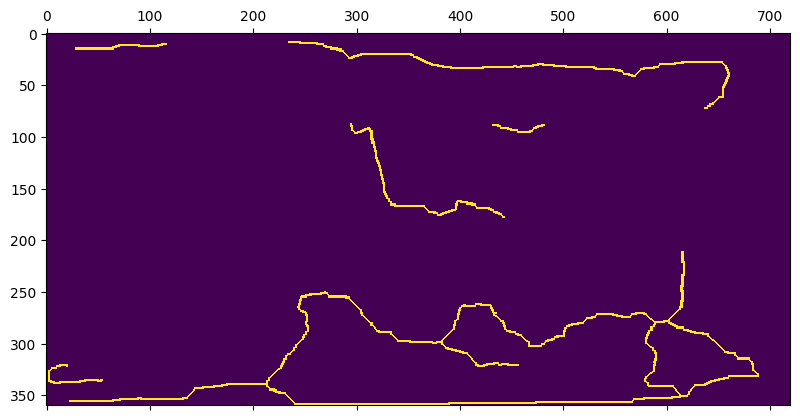

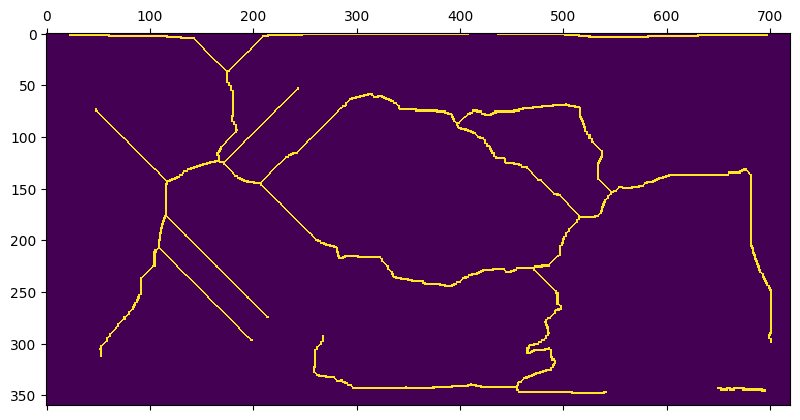

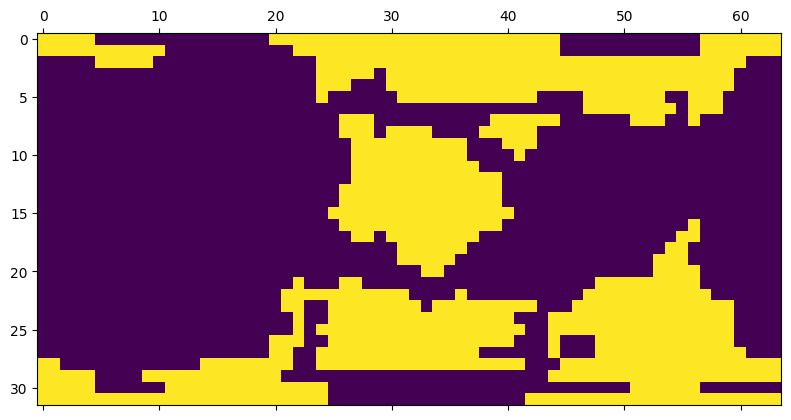

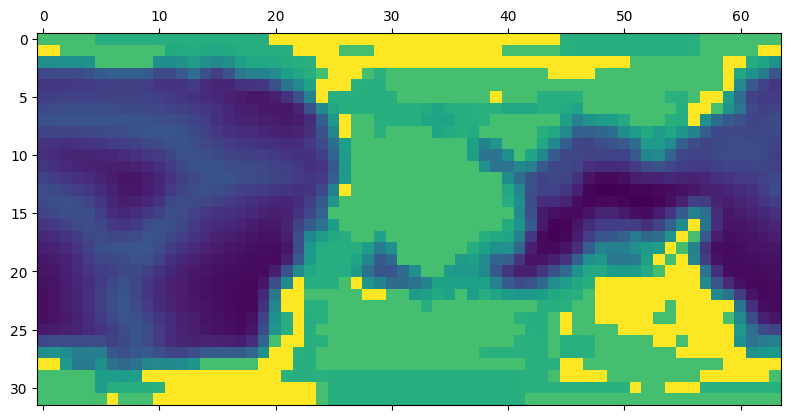

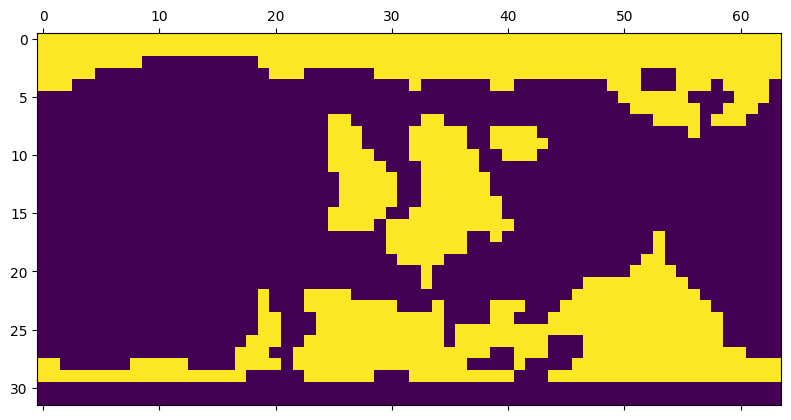

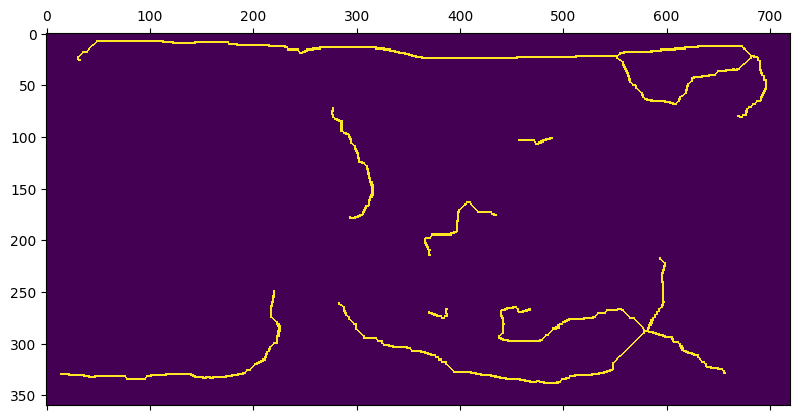

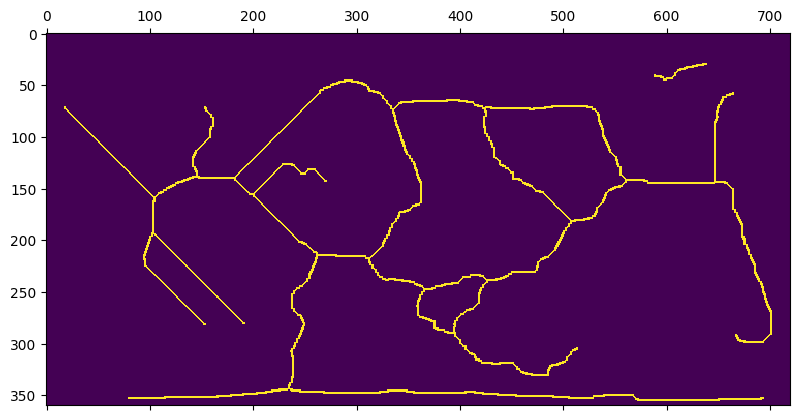

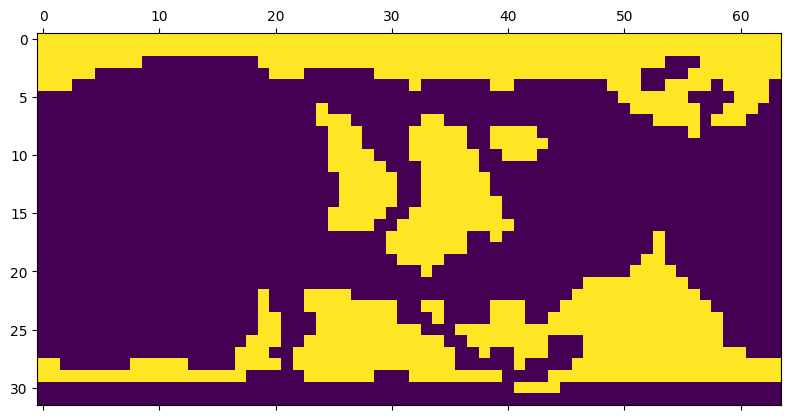

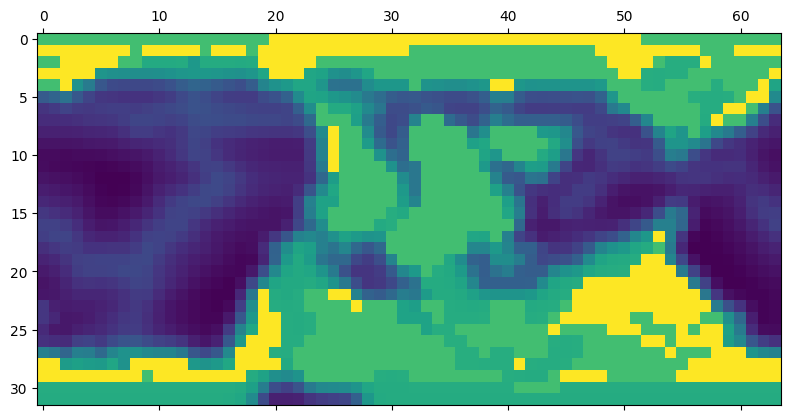

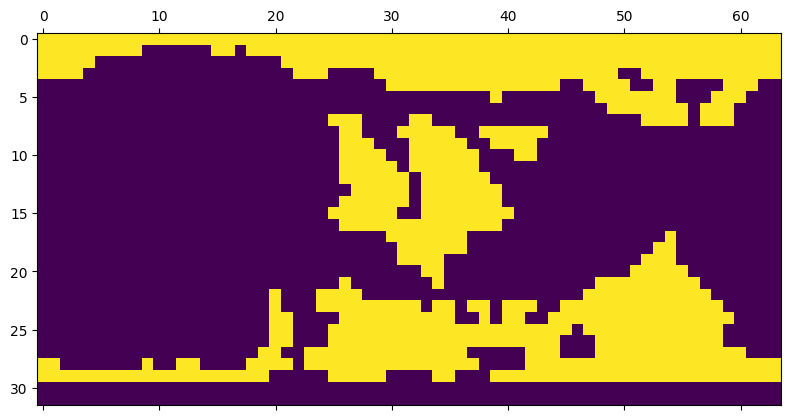

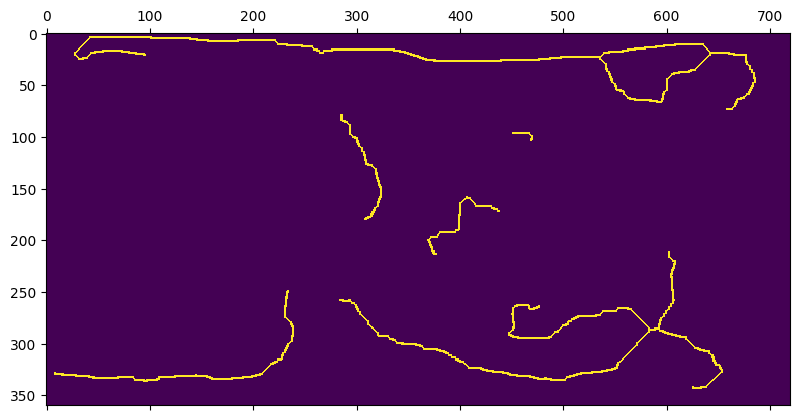

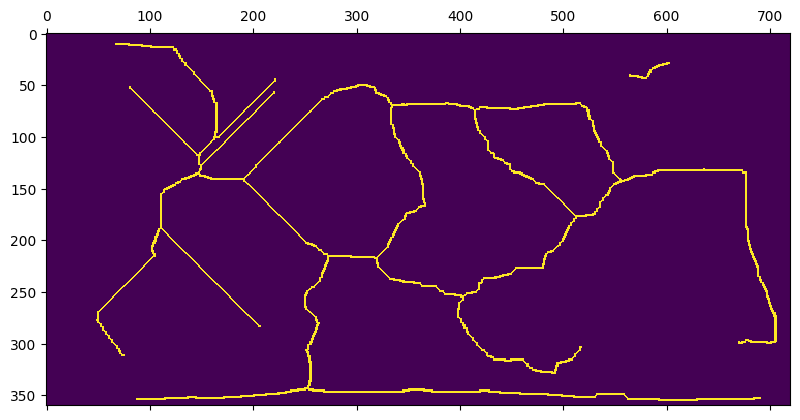

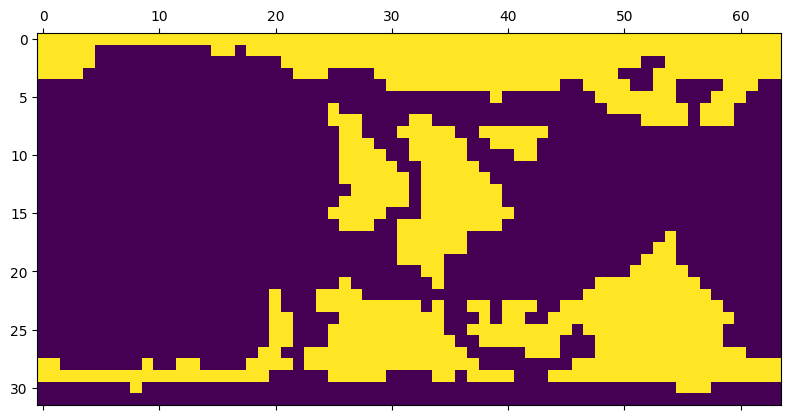

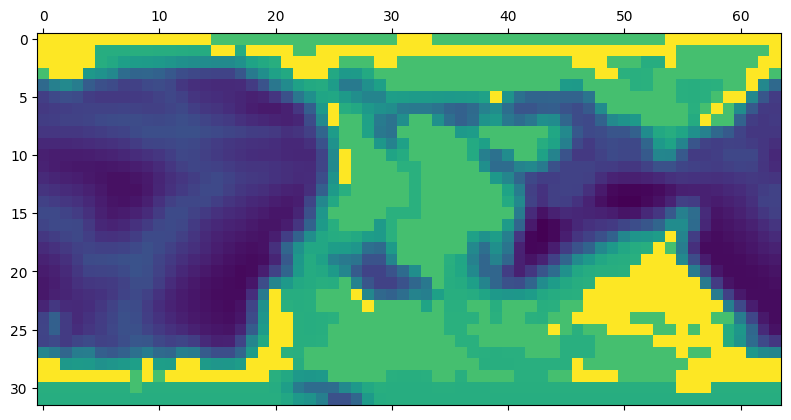

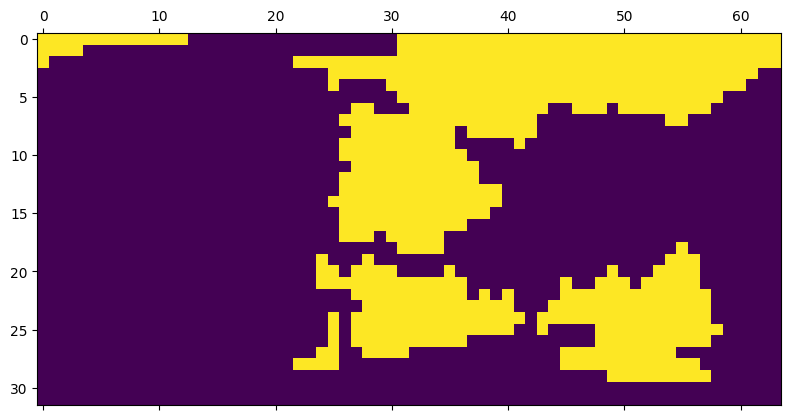

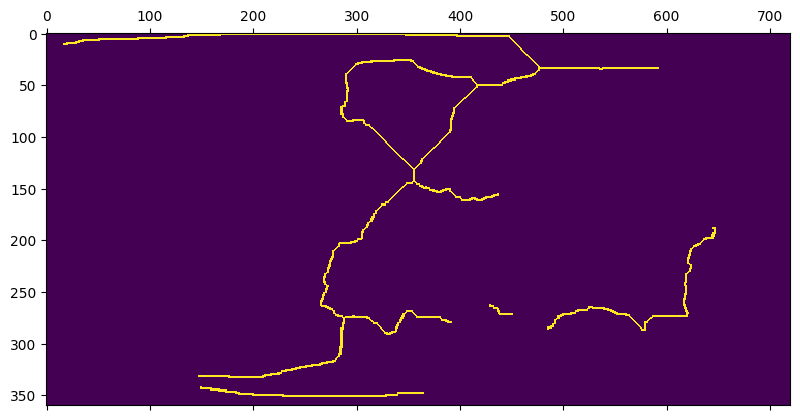

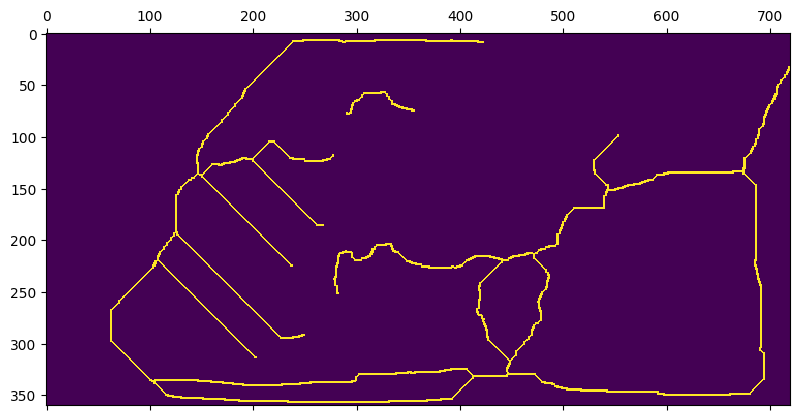

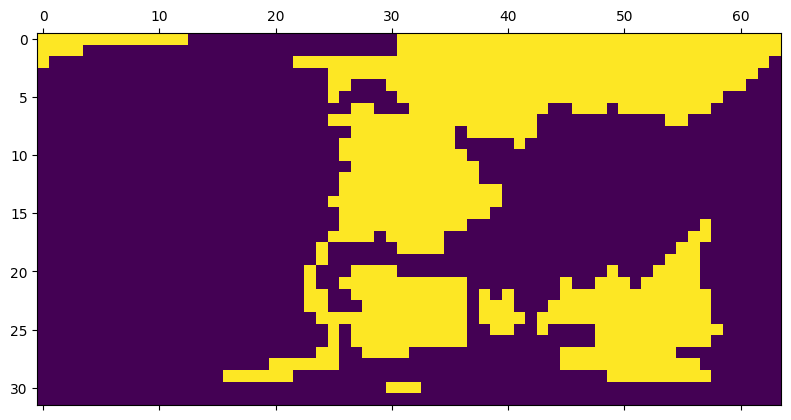

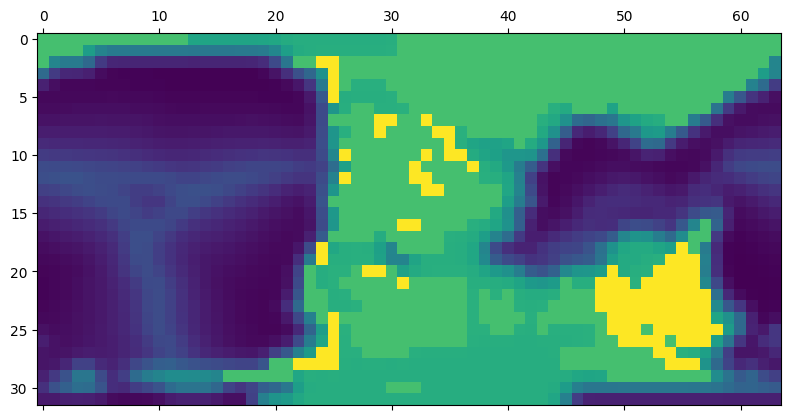

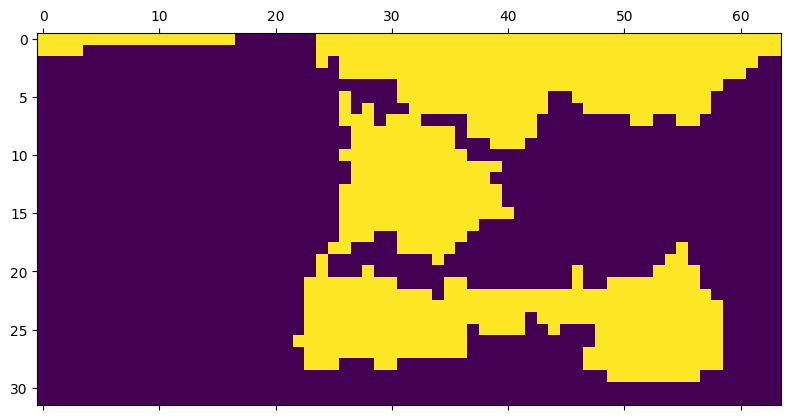

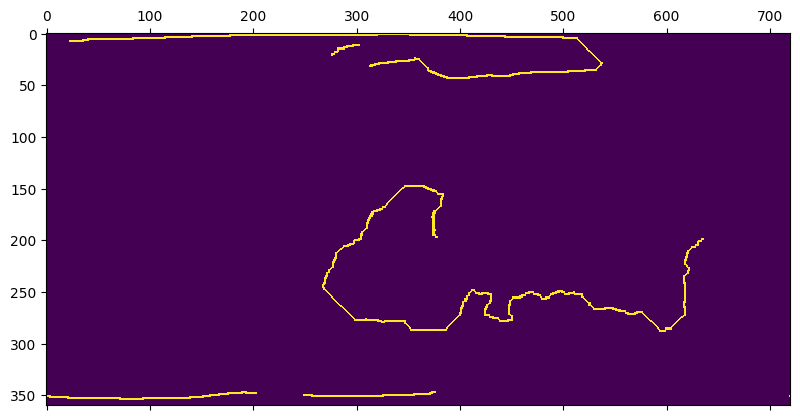

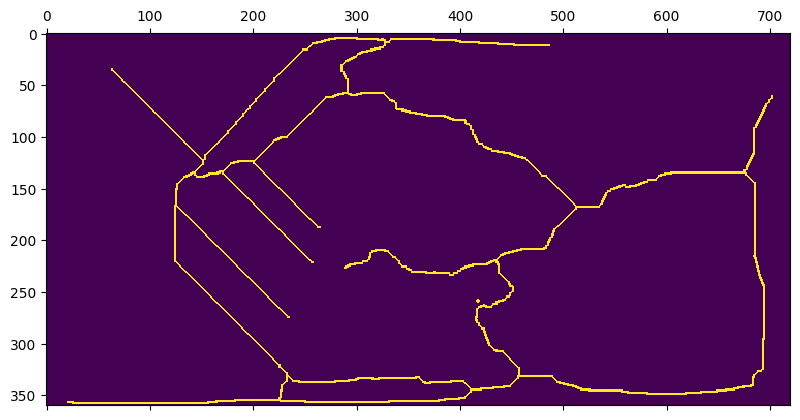

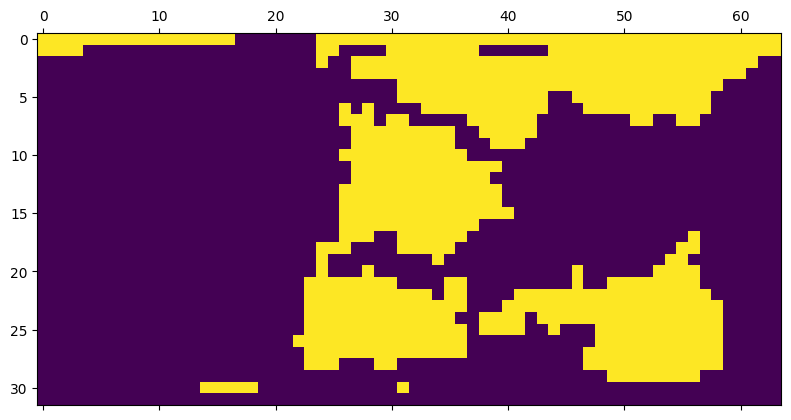

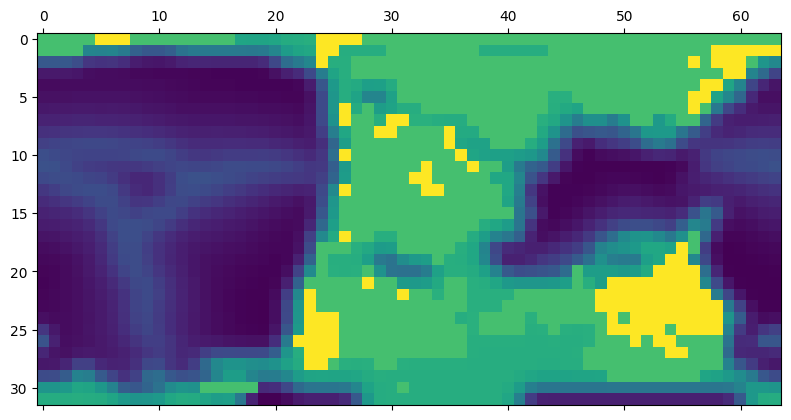

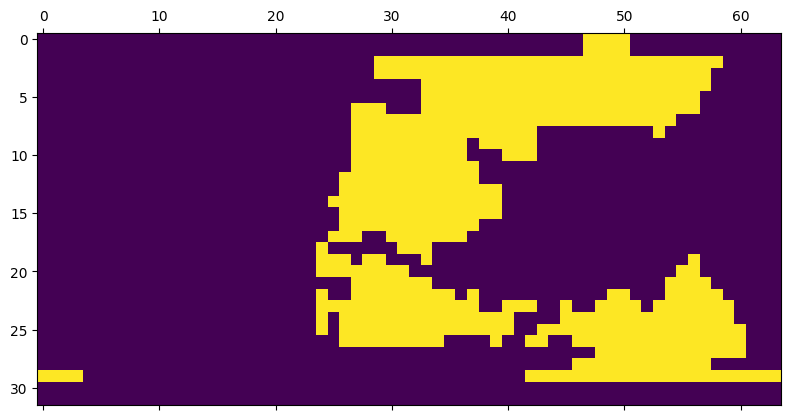

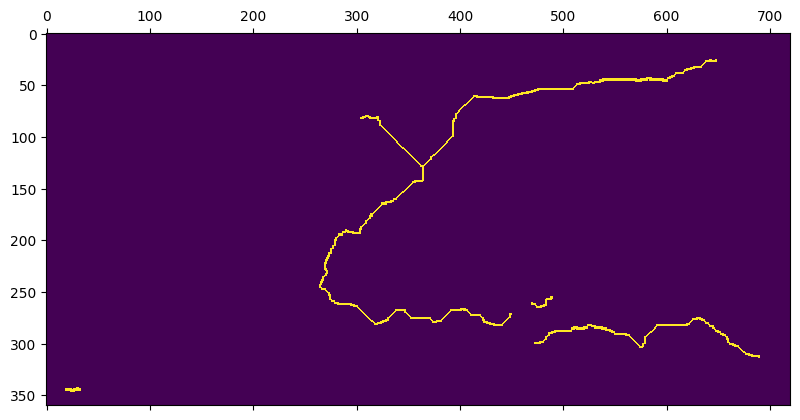

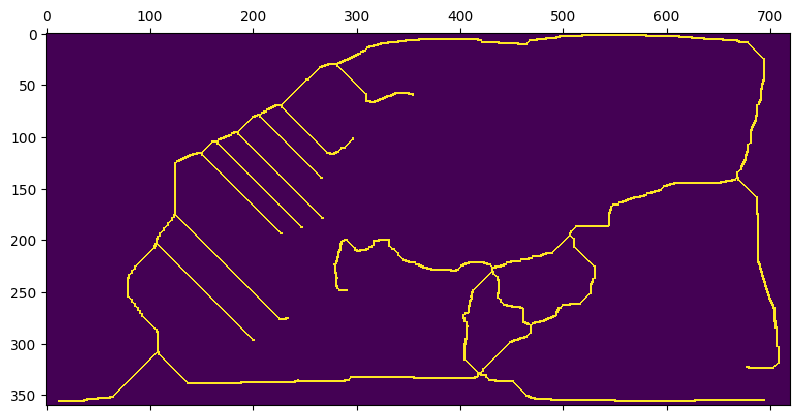

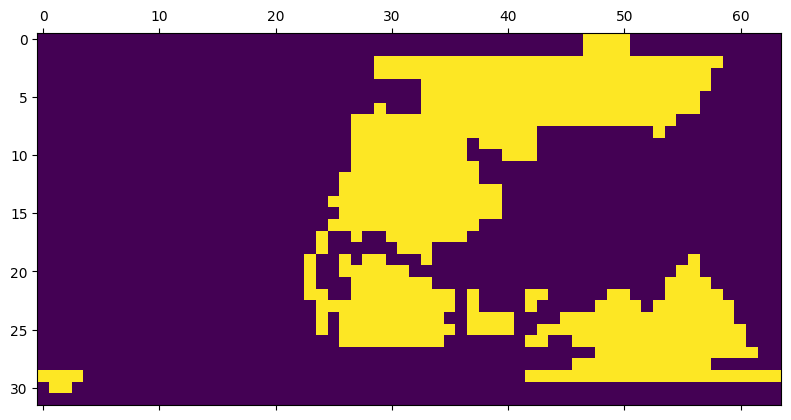

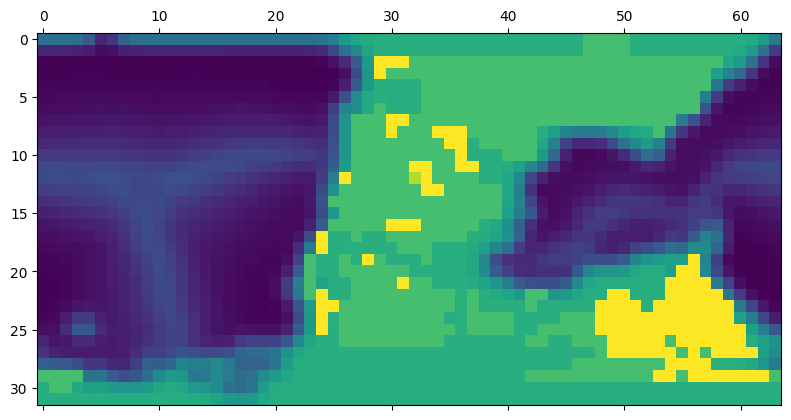

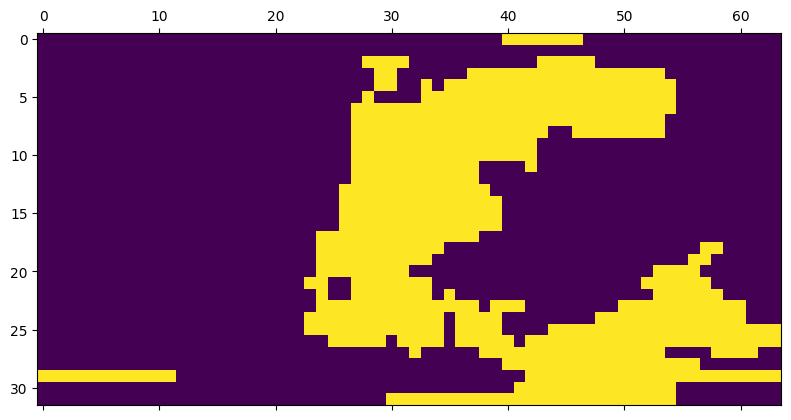

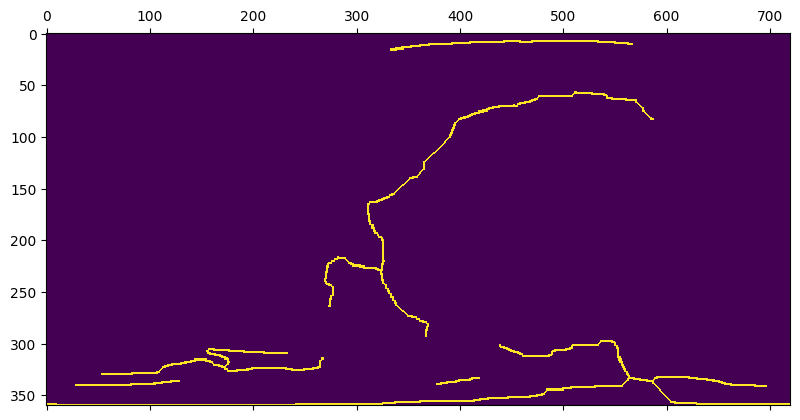

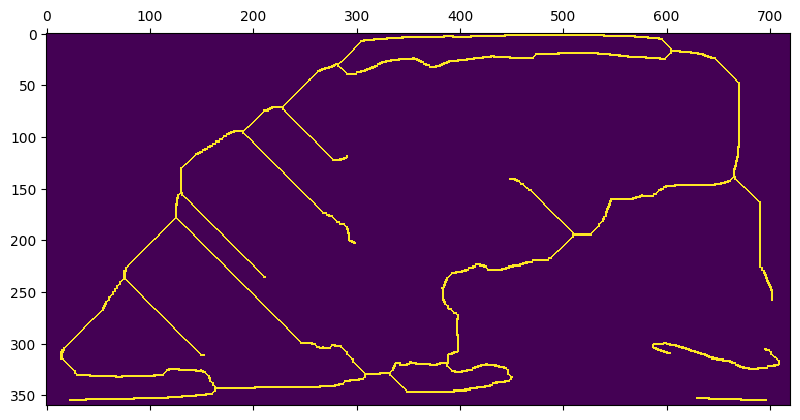

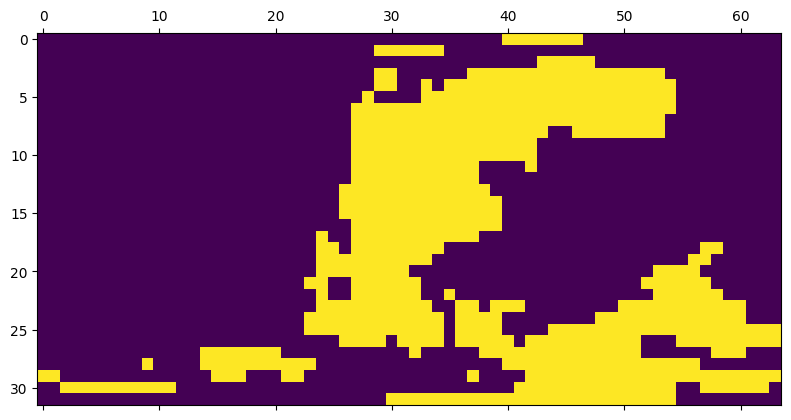

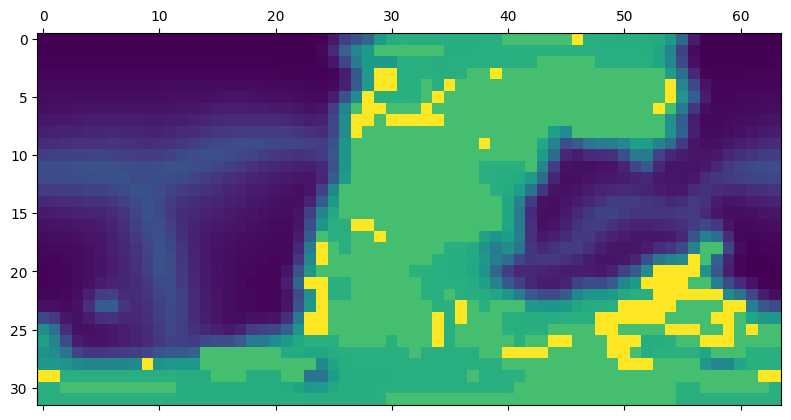

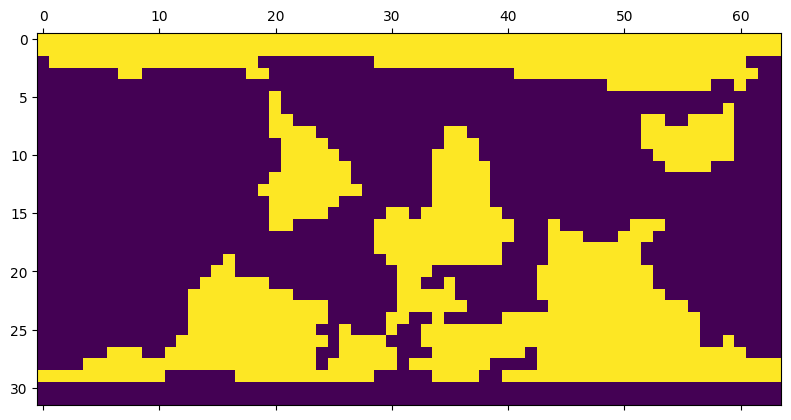

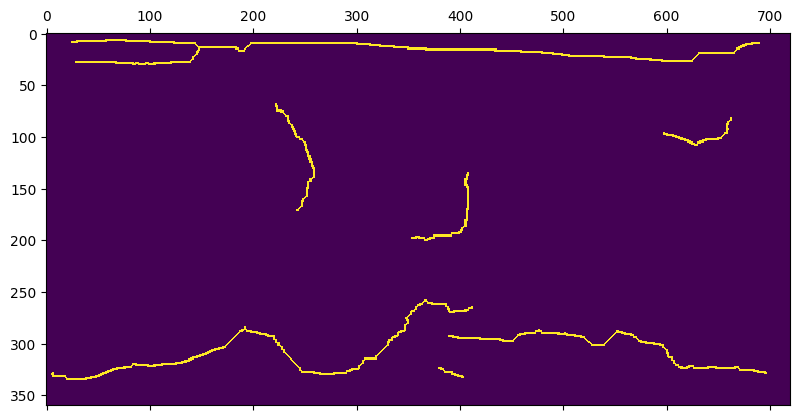

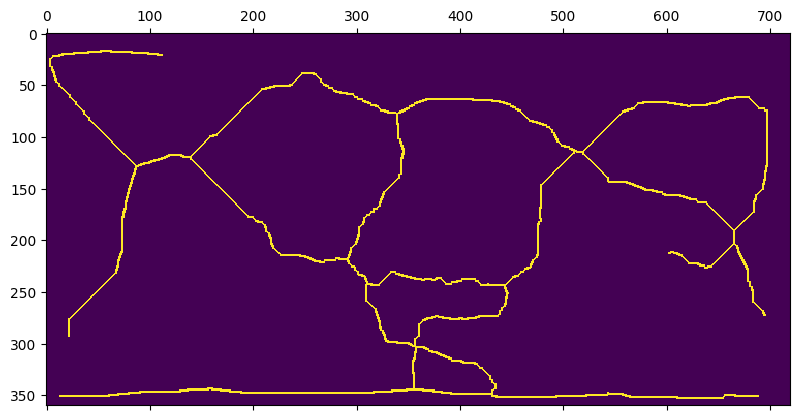

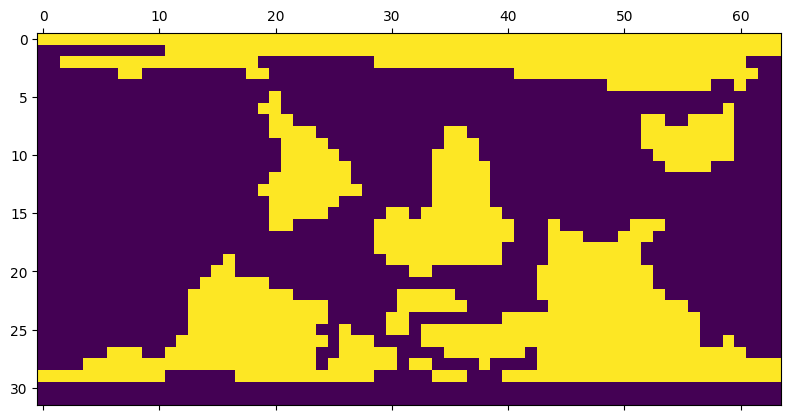

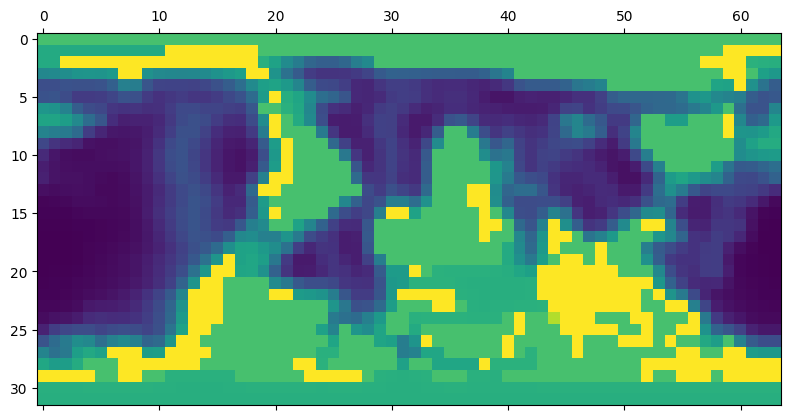

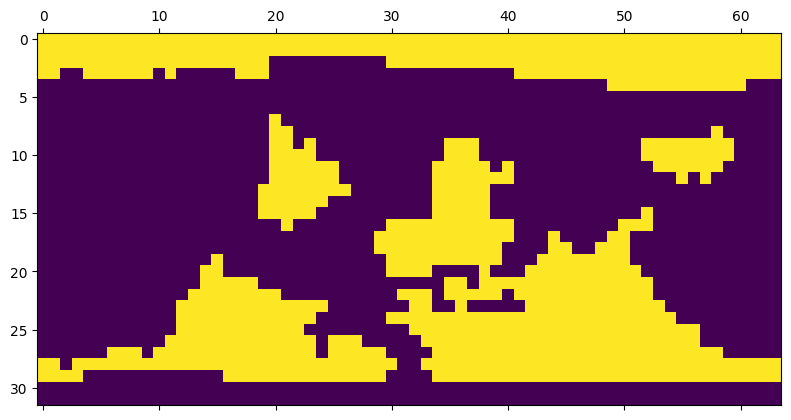

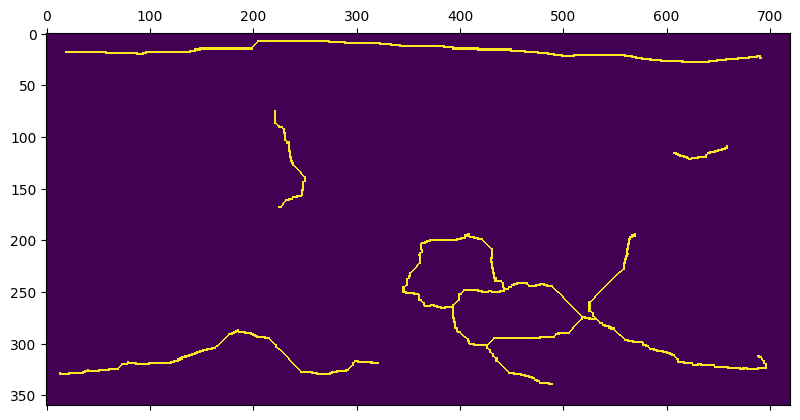

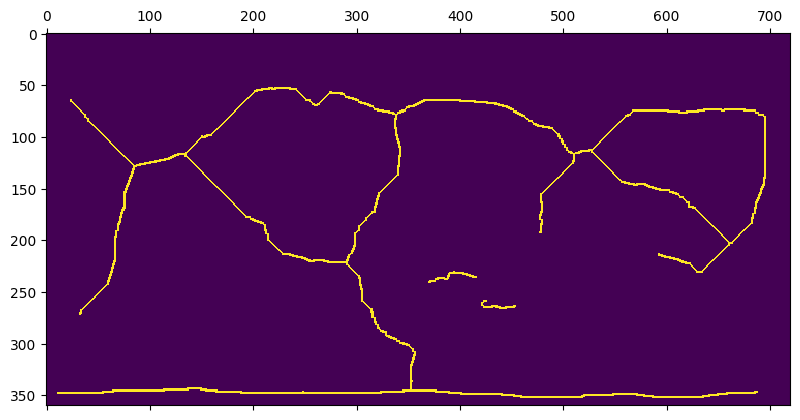

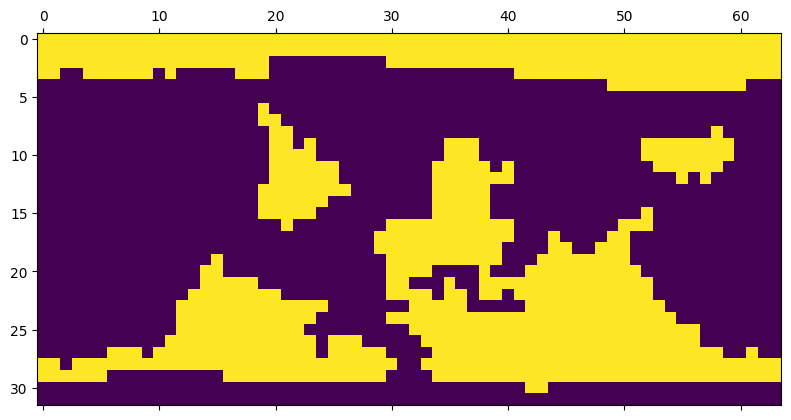

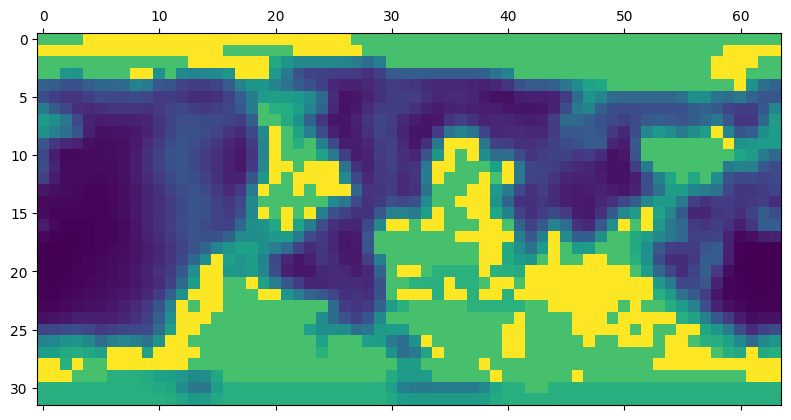

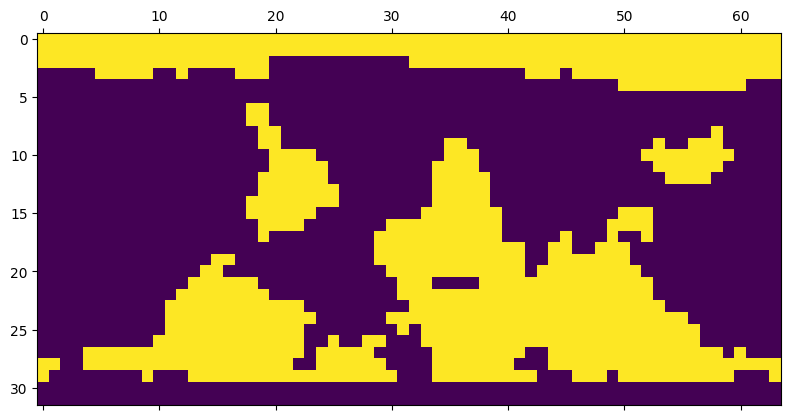

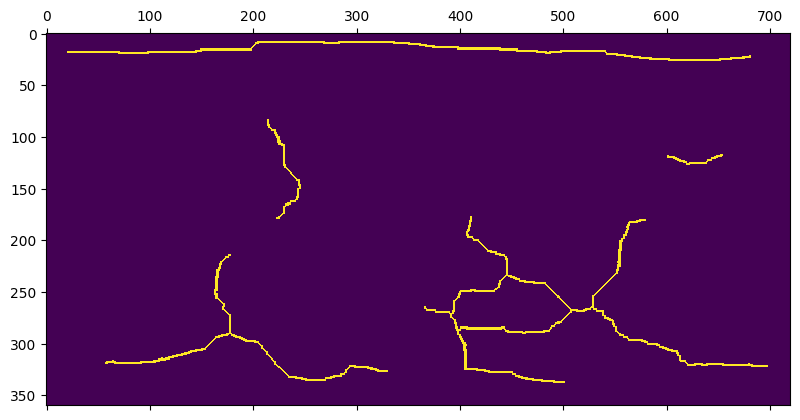

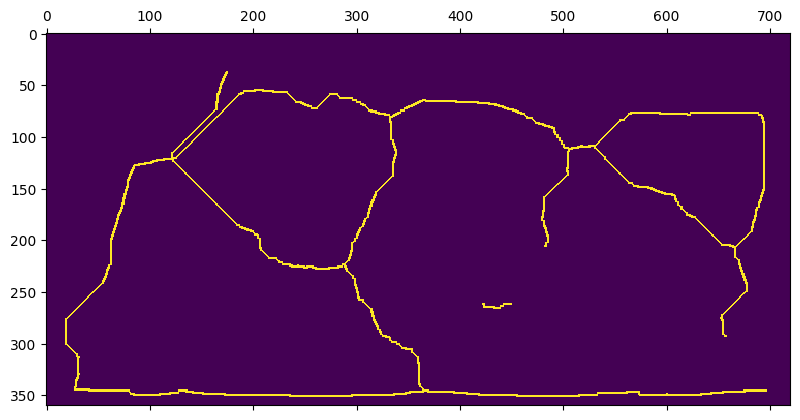

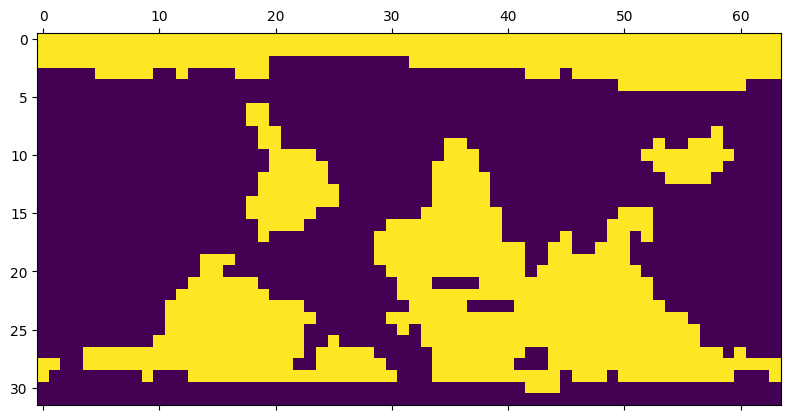

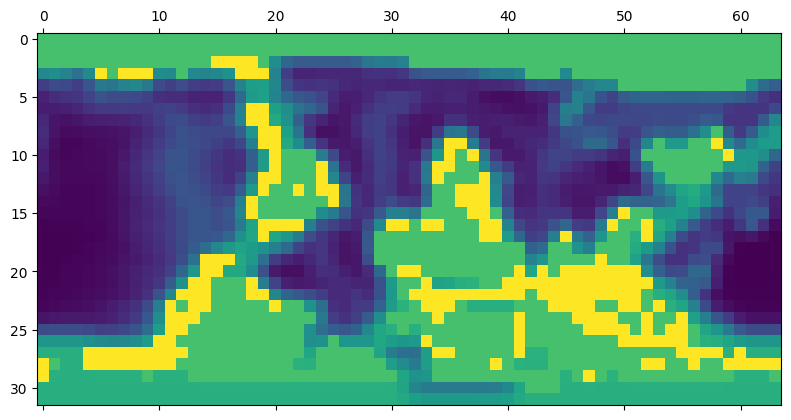

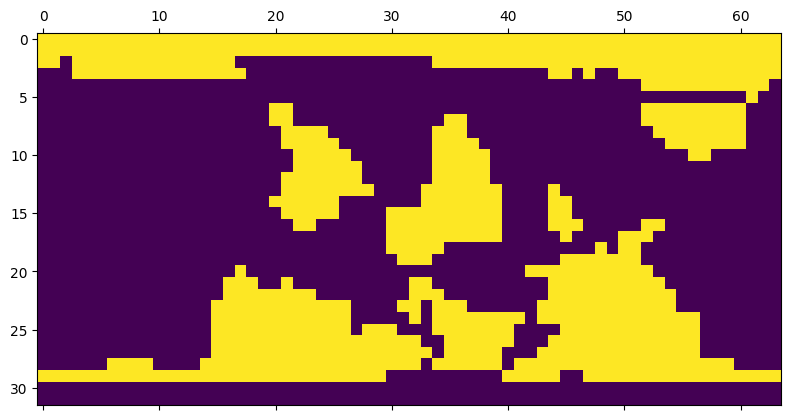

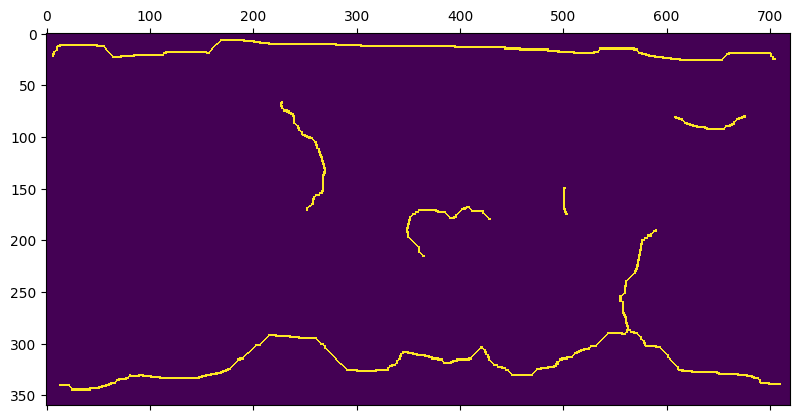

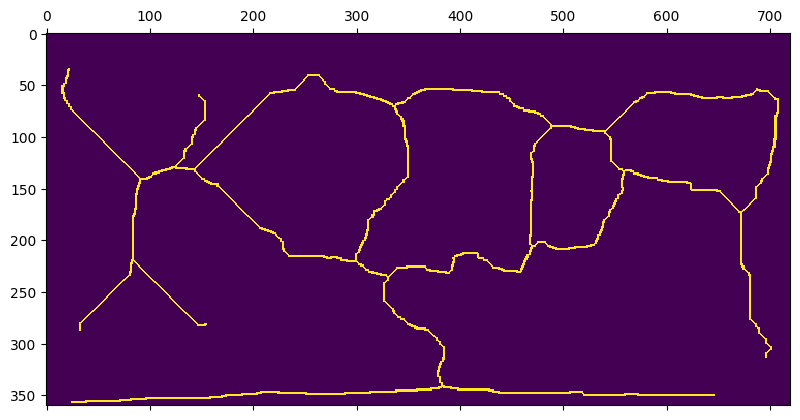

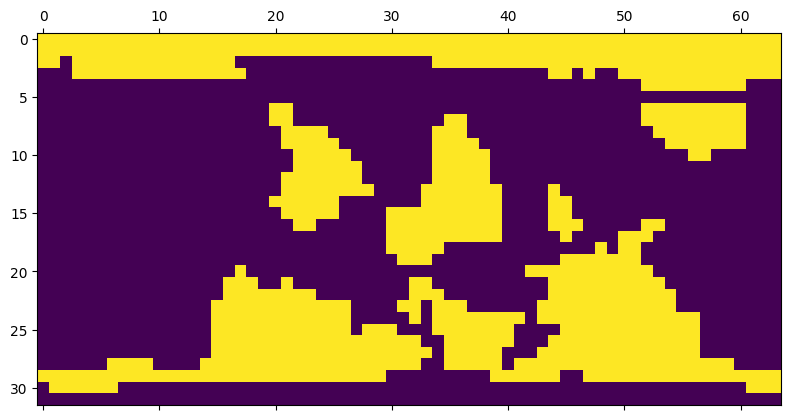

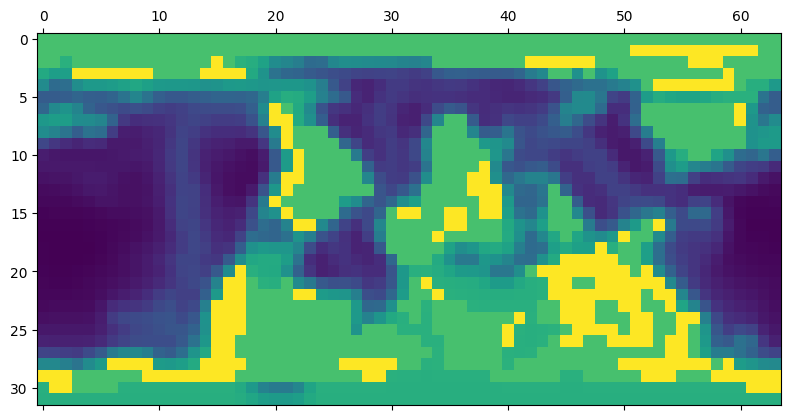

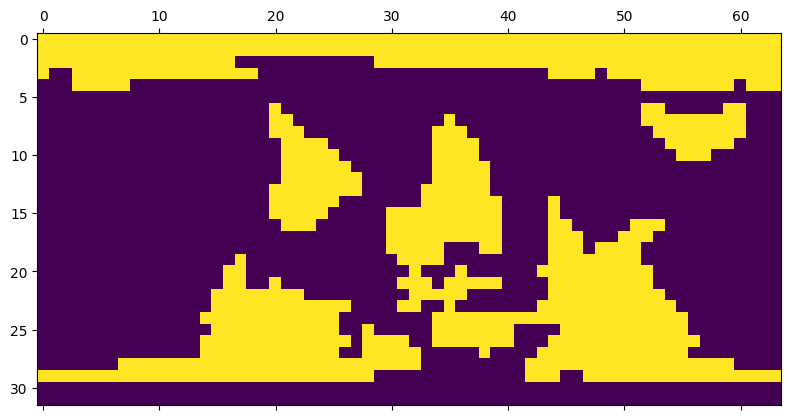

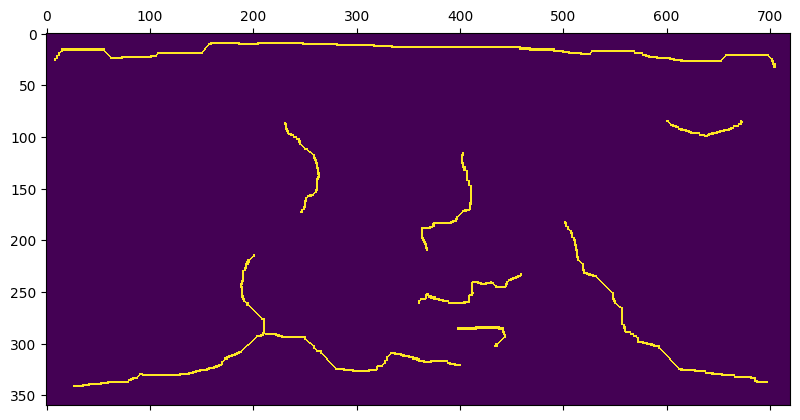

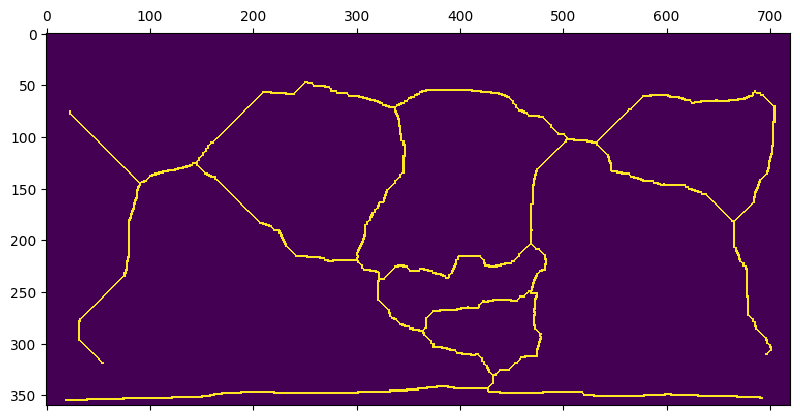

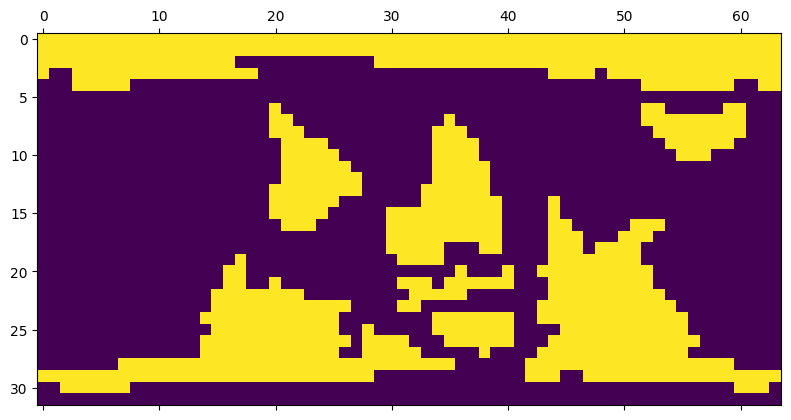

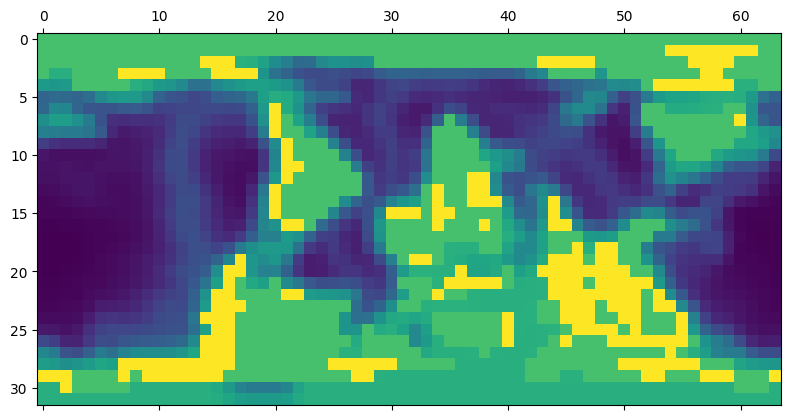

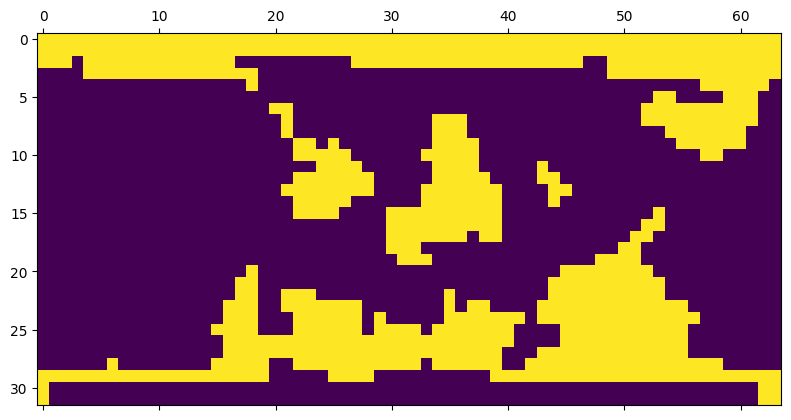

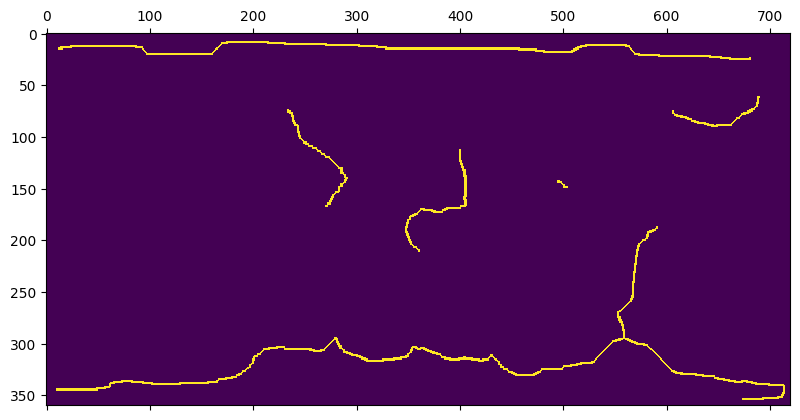

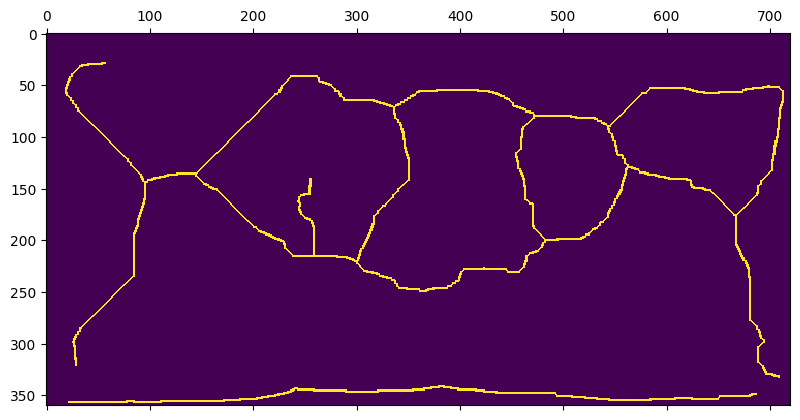

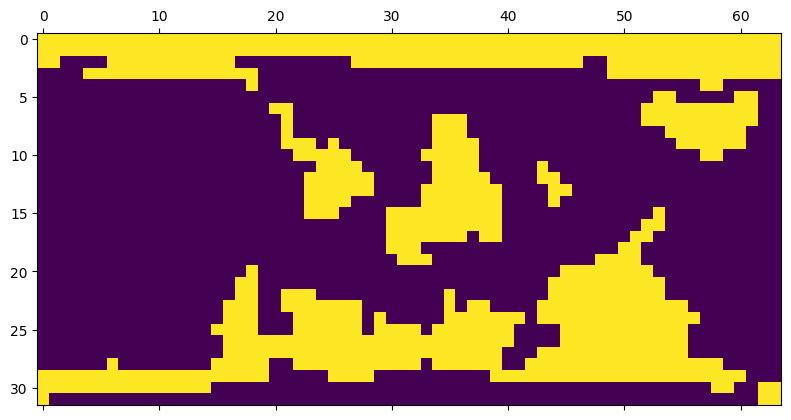

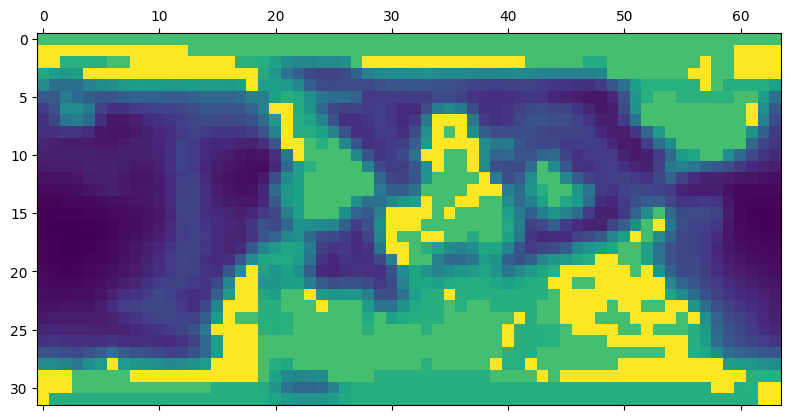

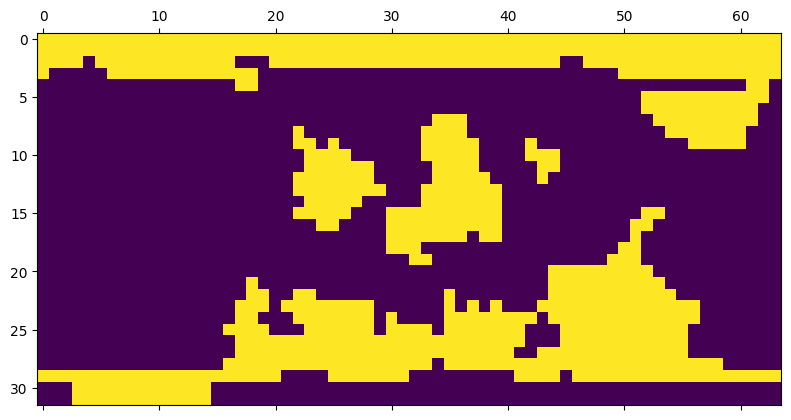

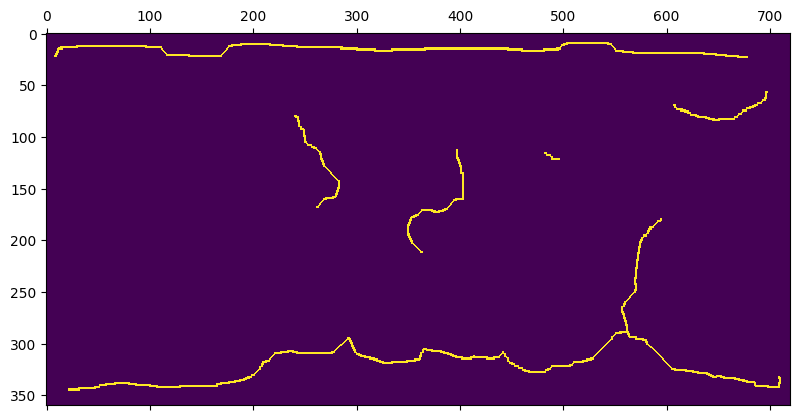

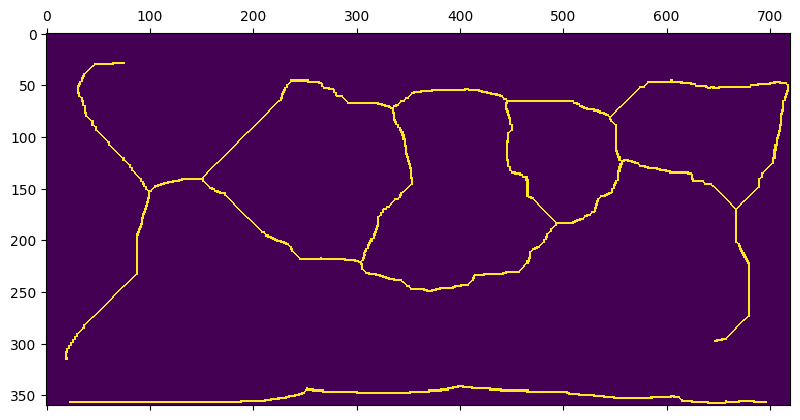

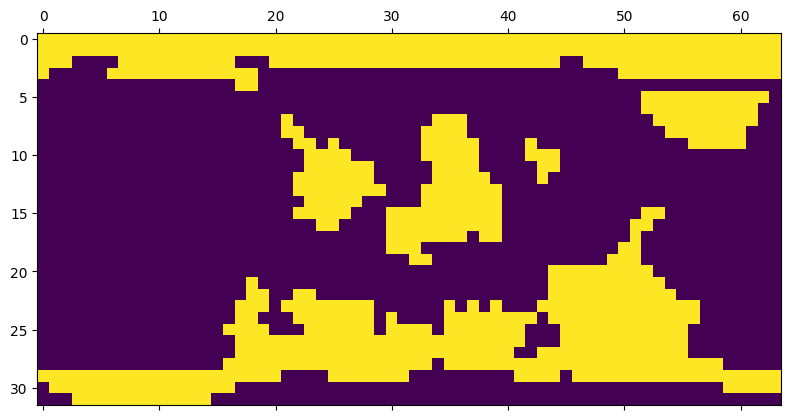

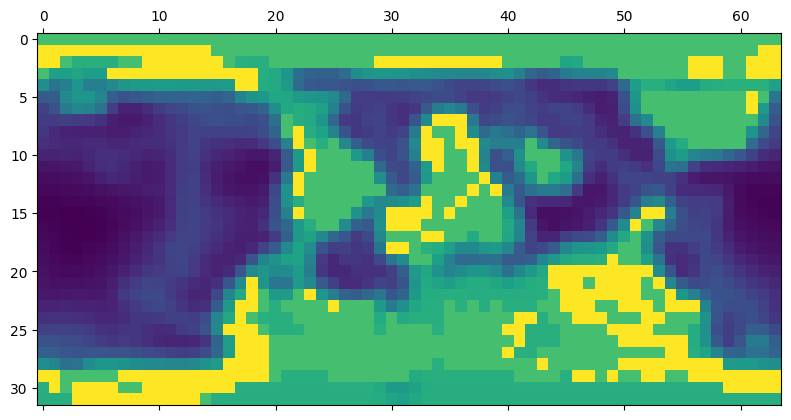

In [4]:
outdir = 'skeletonsEnforced'
if os.path.exists(outdir):
    shutil.rmtree(outdir)
os.makedirs(outdir)

for f in os.listdir(coarsenedPath):
    if f.endswith('.nc'):
        print(f)
        grid = os.path.join(coarsenedPath,f)
        age = f.split('_')[-1].rstrip('.nc') # May need changing based on filename
        land_skel = f'skeletons/skeleton_land_topo_{age}_filled.nc'
        ocean_skel = f'skeletons/skeleton_ocean_topo_{age}_filled.nc'
    else:
        continue   
    # Open the grid as an xarray dataset
    ds = xr.open_dataset(grid)
    ds = pygmt.grdsample(grid=ds['z'], region='d', registration='p')

    # Convert the xarray dataset to a pandas dataframe and preprocess
    df = ds.to_dataframe()
    df = df.reset_index()
    df = df.round(1)

    # Reorganise the dataframe so latitude is the index and longitude and elevation are the column values
    topo = df.pivot(index='lat', columns='lon', values='z').values

    topo = topo.astype(int) # Make every value an integer

    # Save a copy of the original grid for later
    topoOG = topo.copy()

    # Create land and water masks
    land = np.where(topo > 0)
    water = np.where(topo <= 0)

    topo[land] = 999 # Isolate all land elevations and make it a high number
    topo[water] = 0 # Make all water cells zero

    plt.matshow(topo)
    print(age)

    # Translate skeleton to 0-360 lon and the pixel registration
    try:
        os.remove('tmp_land_skel.nc')
        os.remove('tmp_ocean_skel.nc')
    except:
        pass
    with pygmt.clib.Session() as session:
        pygmt.grdsample(grid=f'{land_skel}?pruned_trimmed_skel_noDiagonal', region='d', registration='p', outgrid='tmp_land_skel.nc')
        pygmt.grdsample(grid=f'{ocean_skel}?pruned_trimmed_skel_noDiagonal', region='d', registration='p', outgrid='tmp_ocean_skel.nc')

    # Loop over the landsea coords and check if skeleton falls in those coords
    gridres_lon=64 # Number of columns on the genie grid
    gridres_lat=32 # Number of rows on the genie grid

    halfcell=(360/gridres_lon)/2 # Half the model cell width in degrees
    lats = np.linspace(-90 + halfcell, 90 - halfcell, gridres_lat)
    lons = np.linspace(-180 + halfcell, 180 - halfcell, gridres_lon)

    # Land skeleton
    skel = xr.open_dataset('tmp_land_skel.nc')
    # skel = xr.open_dataset('tmp_ocean_skel.nc')
    skeleton = skel['z']
    skeleton = xr.where(skeleton>=0.2,1,0)
    plt.matshow(skeleton)

    skelDF = skeleton.to_dataframe().reset_index()

    # Create new dataframe with just the places where skeletons are
    # Also filters out skeletons within one grid cell of the poles- makes things less complicated and lets the pole filtering do its thing
    skeleton_ones = skelDF[(skelDF['z'] == 1) & (np.abs(skelDF['lat']) < (90-2*halfcell))]
    lats_ones = skeleton_ones['lat'].values.tolist()
    lons_ones = skeleton_ones['lon'].values.tolist()

    count=0
    for i in range(len(lats)):
        lat = lats[i]
        for j in range(len(lons)):
            lon = lons[j]

            val = topo[i][j]

            if int(val)==999:
                continue

            # Define bounding box
            lat_min = lat - halfcell
            lat_max = lat + halfcell
            lon_min = lon - halfcell
            lon_max = lon + halfcell


            for lat_one, lon_one in zip(lats_ones, lons_ones):
                if (lat_min <= lat_one <= lat_max) and (lon_min <= lon_one <= lon_max):
                    count+=1

                    # Change the cell in 'landsea' to 1
                    # condition = (landsea['lat'] == lat) & (landsea['lon'] == lon)
                    # landsea = landsea.where(~condition, 1)
                    topo[i][j] = 999

                    print(f"Lat extent of big cell: {lat_min, lat_max}")
                    print(f"Lon extent of big cell: {lon_min, lon_max}")
                    print(f"Lat, Lon of the skeleton cell: {lat, lon}\n")
                    break  # Breaks the loop as soon as one match is found within a cell	
    print(f"Number of times the skeleton fell within a land cell: {count}/{len(lats_ones)}")

    # Ocean skeleton
    # skel = xr.open_dataset('tmp_land_skel.nc')
    skel = xr.open_dataset('tmp_ocean_skel.nc')
    skeleton = skel['z']
    skeleton = xr.where(skeleton>=0.2,1,0)
    plt.matshow(skeleton)

    skelDF = skeleton.to_dataframe().reset_index()

    # Create new dataframe with just the places where skeletons are
    # Also filters out skeletons within one grid cell of the poles- makes things less complicated and lets the pole filtering do its thing
    skeleton_ones = skelDF[(skelDF['z'] == 1) & (np.abs(skelDF['lat']) < (90-2*halfcell))]
    lats_ones = skeleton_ones['lat'].values.tolist()
    lons_ones = skeleton_ones['lon'].values.tolist()

    count=0
    for i in range(len(lats)):
        lat = lats[i]
        for j in range(len(lons)):
            lon = lons[j]

            val = topo[i][j]

            if int(val)==0:
                continue

            # Define bounding box
            lat_min = lat - halfcell
            lat_max = lat + halfcell
            lon_min = lon - halfcell
            lon_max = lon + halfcell


            for lat_one, lon_one in zip(lats_ones, lons_ones):
                if (lat_min <= lat_one <= lat_max) and (lon_min <= lon_one <= lon_max):
                    count+=1

                    # Change the cell in 'landsea' to 1
                    # condition = (landsea['lat'] == lat) & (landsea['lon'] == lon)
                    # landsea = landsea.where(~condition, 1)
                    topo[i][j] = 0

                    print(f"Lat extent of big cell: {lat_min, lat_max}")
                    print(f"Lon extent of big cell: {lon_min, lon_max}")
                    print(f"Lat, Lon of the skeleton cell: {lat, lon}\n")
                    break  # Breaks the loop as soon as one match is found within a cell	
    print(f"Number of times the skeleton fell within a land cell: {count}/{len(lats_ones)}")

    plt.matshow(topo)

    # Convert back to original topographys
    max_lat = topoOG.shape[0] - 1
    max_lon = topoOG.shape[1] - 1

    #Make sure both grids are the same type
    original_grid = topoOG.astype(float)
    filtered_grid = topo.astype(float)

    for i in range(len(original_grid)):
        for j in range(len(original_grid[i])):
            original = original_grid[i][j]
            filtered = filtered_grid[i][j]

            # Identify the surrounding cells
            left = original_grid[i][j-1]
            if j == max_lon:
                right = original_grid[i][0] # Because the longitudes touch each other (it's a globe afterall)
            elif j != max_lon:
                right = original_grid[i][j+1]
            if i == 0:
                above = None
            elif i != 0:
                above = original_grid[i-1][j]
            if i == max_lat:
                below = None 
            elif i != max_lat:
                below = original_grid[i+1][j]

            surrounds = [above, below, right, left]
            surrounds = [val for val in surrounds if val is not None] # remove none values
            land_surrounds = [val for val in surrounds if val >= 0] # record just surrounds that are above sea level
            water_surrounds = [val for val in surrounds if val < 0] # record just bethymetries of surrounds

            if original >= 0 and filtered == 999:
                continue
            elif original <0 and filtered < 999:
                continue
            elif original < 0 and filtered == 999:
                if len(land_surrounds) > 0 and np.min(land_surrounds) > 0:
                    original_grid[i][j] = np.min(land_surrounds) # Make the elevation of any converted inland seas to the mean of the surrounding land cells
                else:
                    original_grid[i][j] = 500.
            elif original >= 0 and filtered < 999: # Shouldn't have any issues here unless we removed more than single cell islands only
                if len(water_surrounds) > 0 and np.max(water_surrounds) < 0:
                    original_grid[i][j] = np.max(water_surrounds) # Make the elevation of any converted islands to ocean to the mean of the surrounding cells
                else:
                    original_grid[i][j] = -200.
    plt.matshow(original_grid)

    # Convert to raster by incorporating into a copy of the original coarsened grid
    outname = f'skeleton_enforced_{age}.nc'
    if os.path.exists(outname):
        os.remove(outname)

    shutil.copy(f'{grid}', os.path.join(os.getcwd(), outname))

    # Open the netCDF file
    dataset = nc.Dataset(outname, mode='r+')

    var = dataset.createVariable('skeletonEnforced', np.float64, dataset.variables['z'].dimensions)
    # Save the 'skel' array to the new variable
    var[:] = original_grid
    dataset.close()
    
    # Move new grid with enforced gateways to it's own directory
    shutil.move(outname, outdir)